In [21]:
import src
import keras.backend as K
import os
import numpy as np
import sys
import re
import math
import io
from scipy.ndimage.filters import gaussian_filter
from scipy import ndimage
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from  matplotlib.animation import FuncAnimation
from matplotlib import colors
from netCDF4 import Dataset
from IPython.display import clear_output
#data folder
sys.path.insert(0, 'C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/data')
#forces CPU usage
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #"" or "-1" for CPU, "0" for GPU
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16752949066940174649
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1508248780
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13765146838396905957
physical_device_desc: "device: 0, name: GeForce GT 740M, pci bus id: 0000:01:00.0, compute capability: 3.5"
]


In [60]:
def sample_images(epoch, gan_test, gan_test_truth, past_input):
    n = 5
    test_batch = gan_test[:n,:,:,1:]
    test_truth = gan_test_truth[:n]
    gen_imgs = generator.predict(test_batch)
    fig, axs = plt.subplots(n, past_input+2, figsize=(16, 16))
    for i in range(n):
        vmax = np.max([np.max(test_batch[i]), np.max(test_truth[i])])
        vmin = 0
        for j in range(past_input):
            im = axs[i,j].imshow(test_batch[i, :,:,j], vmax=vmax,vmin=vmin)
            axs[i,j].axis('off')
            src.colorbar(im)
            axs[i,j].set_title("Frame t"+str([-past_input+1+j if j < past_input-1 else ""][0]))
        im2 = axs[i,-2].imshow(test_truth[i, :,:,0], vmax=vmax, vmin=vmin)
        axs[i,-2].axis('off')
        src.colorbar(im2)                
        axs[i,-2].set_title("Frame t+1")
        im3 = axs[i,-1].imshow(gen_imgs[i, :,:,0], vmax=vmax, vmin=vmin)
        axs[i,-1].axis('off')
        src.colorbar(im3)
        axs[i,-1].set_title("Prediction t+1")
    fig.savefig("Plots/epoch %d.png" % epoch)
    plt.close()
    
def noisy_d_labels(real, fake):
    # idea: https://arxiv.org/pdf/1606.03498.pdf
    batch_size = len(real)
    five_percent = int(0.05*batch_size)
    idx = np.random.randint(0, batch_size, five_percent)
    d_real = np.ones_like(real)
    d_fake = np.zeros_like(fake)
    d_real[idx] = 0
    d_fake[idx] = 1
    return d_real, d_fake

def plot_advections(advected_aux_gen, advected_aux_truth):
    gen = advected_aux_gen[:5]
    truth =  advected_aux_truth[:5]
    fig, axs = plt.subplots(5, 2, figsize=(16, 16))
    for i in range(5):
        vmax = np.max([np.max(gen[i]), np.max(truth[i])])
        vmin = 0
        im = axs[i,0].imshow(gen[i, :,:,0], vmax=vmax,vmin=vmin)
        axs[i,0].axis('off')
        src.colorbar(im)
        axs[i,0].set_title("Advected generated frame")
        
        im = axs[i,1].imshow(truth[i, :,:,0], vmax=vmax,vmin=vmin)
        axs[i,1].axis('off')
        src.colorbar(im)
        axs[i,1].set_title("Advected reference frame")
        
    fig.savefig("Plots/advections_epoch %d.png" % epoch)
    plt.close()

In [23]:
past = 1
name = f"tgan_{past}-1"

Load dataset.

In [24]:
train, xval, test = src.load_datasets(past_frames=past+1)

Training data: (7500, 64, 64, 3)
Validation data: (1500, 64, 64, 3)
Test data: (1000, 64, 64, 3)


Split data to inputs and ground truth images.

In [25]:
gan_train, gan_truth, gan_val, gan_val_truth, gan_test, gan_test_truth = src.split_datasets(
            train[:2000], xval, test, past_frames=past+1, augment=True)

Data augmentation.
Shape of training data:  (8000, 64, 64, 2) 
Shape of training truth:  (8000, 64, 64, 1) 
Shape of validation data:  (1500, 64, 64, 2) 
Shape of validation truth:  (1500, 64, 64, 1) 
Shape of test data:  (1000, 64, 64, 2) 
Shape of test truth:  (1000, 64, 64, 1)


Calculate optical flows between frame t-1 and t.

In [ ]:
#optical flow of the augmented data of the first 2000 training images (8000 images)
#vx, vy = src.optical_flow(gan_train[:,:,:,-2:-1], gan_train[:,:,:,-1:], window_size=4, tau=1e-2, init=1) # (n,:,:,1)

Save optical flows

In [ ]:
#np.savez_compressed(f"{name}_vx_2000",vx) #2000 denotes that they re the flo2 of the first 2000 samples from the training dataset
#np.savez_compressed(f"{name}_vy_2000",vy)

If optical flows are saved, load them

In [26]:
vx = np.load(sys.path[0]+f"/{name}_vx_2000.npz")["arr_0"]
vy = np.load(sys.path[0]+f"/{name}_vy_2000.npz")["arr_0"]

Normalize flows

In [27]:
normalized_optical_flow = src.normalize_flows(vx, vy)

Smooth flows.

In [28]:
median = np.transpose([[ndimage.median_filter(image[...,ch], 4) for ch in range(2)] for image in normalized_optical_flow], (0,2,3,1))

In [ ]:
#gauss_normalized_optical_flow = gaussian_filter(median, sigma=2)

In [ ]:
s = 6144
plt.subplot(1,2,1)
plt.imshow(normalized_optical_flow[s,...,0],cmap="seismic", vmin=-1, vmax=1)
plt.colorbar(shrink=0.43)
plt.subplot(1,2,2)
plt.imshow(median[s,...,0],cmap="seismic",vmin=-1,vmax=1)
plt.colorbar(shrink=0.43)
plt.subplot(1,2,2)

In [ ]:
plt.subplot(1,2,1)
plt.imshow(gan_train[s,...,-2])
plt.colorbar(shrink=0.43)
plt.subplot(1,2,2)
plt.imshow(gan_train[s,...,-1])
plt.colorbar(shrink=0.43)

Make discriminator labels.

In [29]:
batch_size=64

In [30]:
# Adversarial ground truths
real = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))
#Generator ground truths
g_real = np.ones((batch_size, 1))

In [31]:
real, fake = noisy_d_labels(real, fake)

Make generator but don't compile.

In [61]:
generator = src.unet((64, 64, past), dropout=0, batchnorm=True)

Make discriminators and compile.

In [62]:
s_discriminator = src.spatial_discriminator(condition_shape=(64, 64, past), dropout = 0.25, batchnorm=True)
s_discriminator.compile(loss=keras.losses.binary_crossentropy,optimizer=keras.optimizers.SGD(),
                      metrics=[keras.metrics.binary_accuracy])

In [63]:
t_discriminator = src.temporal_discriminator(dropout = 0.25, batchnorm=True)
t_discriminator.compile(loss=keras.losses.binary_crossentropy,optimizer=keras.optimizers.SGD(),
                      metrics=[keras.metrics.binary_accuracy])

Inputs and outputs of the GAN.

In [64]:
frame_t = keras.layers.Input(shape=(64, 64, past))
adv = keras.layers.Input(shape=(64, 64, 1))

In [65]:
generated = generator(frame_t)
s_score = s_discriminator([frame_t, generated])
t_score = t_discriminator([adv, generated])

Freeze discriminator weights.

In [66]:
s_discriminator.trainable = False
t_discriminator.trainable = False

Compile combined model.

In [67]:
loss_weights=[5, 1, 0.1]

In [68]:
combined = keras.models.Model(inputs=[frame_t, adv], outputs=[generated, s_score, t_score])

In [69]:
combined.compile(loss=[src.custom_loss(loss="l1"),
                       keras.losses.binary_crossentropy,
                       keras.losses.binary_crossentropy],
                 optimizer=keras.optimizers.Adam(0.0002, 0.5),
                 loss_weights=loss_weights,
                 metrics=[src.relative_error_tensor, "accuracy", "accuracy"])

***Using L1 loss.***
Tensor("metrics_11/relative_error_tensor/truediv:0", shape=(), dtype=float32)
Tensor("model_13_target:0", shape=(?, ?, ?, ?), dtype=float32)
Tensor("metrics_11/relative_error_tensor_1/truediv:0", shape=(), dtype=float32)
Tensor("model_14_target:0", shape=(?, ?), dtype=float32)
Tensor("metrics_11/relative_error_tensor_2/truediv:0", shape=(), dtype=float32)
Tensor("model_15_target:0", shape=(?, ?), dtype=float32)


Train x epochs.

In [70]:
epochs = 2500

In [71]:
log = {"g_loss":[],
       "d_loss":[],
       "ds_loss":[],
       "dt_loss":[],
       "g_metric":[],
       "d_metric":[],
       "ds_metric":[],
       "dt_metric":[],
       "d_loss_real":[],
       "d_loss_fake":[],
       "ds_loss_real":[],
       "ds_loss_fake":[],
       "dt_loss_real":[],
       "dt_loss_fake":[],}

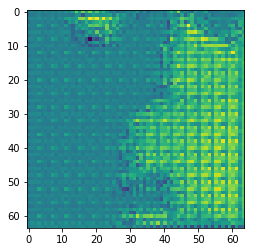

In [72]:
plt.imshow(generated_imgs[0,...,0])

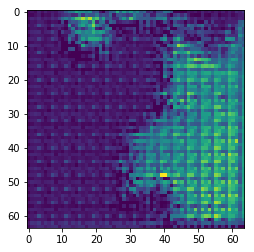

In [73]:
plt.imshow(advected_aux_gen[0,...,0])

In [74]:
for epoch in range(epochs):
#DS create training batch
    s_discriminator.trainable = True
    idx = np.random.randint(0, gan_truth.shape[0], batch_size)
    real_imgs = gan_truth[idx]
    training_batch = gan_train[idx,:,:,1:]
    #predict next frame  
    generated_imgs = generator.predict(training_batch) 
    #train discriminator
    ds_loss_real = s_discriminator.train_on_batch([training_batch, real_imgs], real)
    ds_loss_fake = s_discriminator.train_on_batch([training_batch, generated_imgs], fake)
    #add losses
    ds_loss = 0.5 * np.add(ds_loss_real, ds_loss_fake)
    s_discriminator.trainable = False

#DT create training batch
    t_discriminator.trainable = True
    idx = np.random.randint(0, gan_truth.shape[0], batch_size)
    real_imgs = gan_truth[idx]
    training_batch = gan_train[idx,:,:,1:]
    #predict frame t from frame t-1 and advect
    aux_batch = gan_train[idx,:,:,:-1]
    aux_gen_imgs = generator.predict(aux_batch)
    aux_gen_imgs = np.concatenate((aux_gen_imgs, normalized_optical_flow[idx]), axis=-1)
    advected_aux_gen = np.array([src.advect(sample) for sample in aux_gen_imgs])
    #advect real frame t
    aux_true_imgs = training_batch[:,:,:,-1:]
    aux_true_imgs = np.concatenate((aux_true_imgs, normalized_optical_flow[idx]), axis=-1)
    advected_aux_truth = np.array([src.advect(sample) for sample in aux_true_imgs])
    #predict next frame
    generated_imgs = generator.predict(training_batch) 
    #train discriminator
    dt_loss_real = t_discriminator.train_on_batch([advected_aux_truth, real_imgs], real)
    dt_loss_fake = t_discriminator.train_on_batch([advected_aux_gen, generated_imgs], fake)
    #add losses
    dt_loss = 0.5 * np.add(dt_loss_real, dt_loss_fake)
    t_discriminator.trainable = False
#Total discriminator loss
    d_loss = 0.5 * np.add(ds_loss, dt_loss)
    d_loss_real = 0.5 * np.add(ds_loss_real, dt_loss_real)
    d_loss_fake = 0.5 * np.add(ds_loss_fake, dt_loss_fake)
    
    if epoch%50 == 0 and epoch%100 != 0:
        plot_advections(advected_aux_gen, advected_aux_truth)

#Generator
    idx = np.random.randint(0, gan_train.shape[0], batch_size)
    real_imgs = gan_truth[idx]
    training_batch = gan_train[idx,:,:,1:]
    
    aux_batch = gan_train[idx,:,:,:-1]
    aux_gen_imgs = generator.predict(aux_batch)
    aux_gen_imgs = np.concatenate((aux_gen_imgs, normalized_optical_flow[idx]), axis=-1)
    advected = np.array([src.advect(sample) for sample in aux_gen_imgs])

    g_loss = combined.train_on_batch([training_batch, advected], [real_imgs, g_real, g_real])
    
    log["g_loss"].append(g_loss)
    log["d_loss"].append(d_loss)
    log["ds_loss"].append(ds_loss[0])  
    log["dt_loss"].append(dt_loss[0])
    log["g_metric"].append(g_loss[1])
    log["d_metric"].append(d_loss[1])
    log["ds_metric"].append(ds_loss[1])
    log["dt_metric"].append(dt_loss[1])
    log["d_loss_real"].append(d_loss_real)
    log["d_loss_fake"].append(d_loss_fake)
    log["ds_loss_real"].append(ds_loss_real)
    log["ds_loss_fake"].append(ds_loss_fake)
    log["dt_loss_real"].append(dt_loss_real)
    log["dt_loss_fake"].append(dt_loss_fake)
    
    
    print(f"\033[1m {epoch} [Ds loss: {ds_loss[0]}, acc.: {100*ds_loss[1]}]\033[0m \n"+
          f"\033[1m {epoch} [Dt loss: {dt_loss[0]}, acc.: {100*dt_loss[1]}]\033[0m \n"+
          f"\033[1m {epoch} [G loss: {g_loss[0]}, G obj.: {g_loss[1]}, Gs bce.: {g_loss[2]}, Gt bce.: {g_loss[3]}]\033[0m")
    print(f"S: real loss: {ds_loss_real}, fake loss: {ds_loss_fake}")
    print(f"T: real loss: {dt_loss_real}, fake loss: {dt_loss_fake}")
    if epoch%100 == 0:
        sample_images(epoch, gan_test, gan_test_truth, past)

 0 [Ds loss: 1.1396453380584717, acc.: 30.46875] 
 0 [Dt loss: 1.27143132686615, acc.: 28.90625] 
 0 [G loss: 2.988276720046997, G obj.: 0.3065975308418274, Gs bce.: 1.3379713296890259, Gt bce.: 1.1731797456741333]
S: real loss: [0.8966269, 0.46875], fake loss: [1.3826637, 0.140625]
T: real loss: [0.8100798, 0.484375], fake loss: [1.7327828, 0.09375]
 1 [Ds loss: 1.2399044036865234, acc.: 23.4375] 
 1 [Dt loss: 1.157750129699707, acc.: 31.25] 
 1 [G loss: 2.8472299575805664, G obj.: 0.3017883896827698, Gs bce.: 1.2019175291061401, Gt bce.: 1.3637073040008545]
S: real loss: [1.2241724, 0.203125], fake loss: [1.2556363, 0.265625]
T: real loss: [1.0290965, 0.375], fake loss: [1.2864037, 0.25]
 2 [Ds loss: 1.326282262802124, acc.: 23.4375] 
 2 [Dt loss: 1.1446044445037842, acc.: 28.125] 
 2 [G loss: 2.7586302757263184, G obj.: 0.28861045837402344, Gs bce.: 1.1788877248764038, Gt bce.: 1.3669018745422363]
S: real loss: [1.2558668, 0.1875], fake loss: [1.3966976, 0.28125]
T: real loss: [1.24

 22 [Ds loss: 0.9259282350540161, acc.: 38.28125] 
 22 [Dt loss: 0.7776084542274475, acc.: 50.78125] 
 22 [G loss: 2.0321784019470215, G obj.: 0.23155726492404938, Gs bce.: 0.7796381711959839, Gt bce.: 0.9475386142730713]
S: real loss: [0.8632811, 0.40625], fake loss: [0.98857546, 0.359375]
T: real loss: [0.7938651, 0.53125], fake loss: [0.7613518, 0.484375]
 23 [Ds loss: 1.055949330329895, acc.: 29.6875] 
 23 [Dt loss: 0.7047120332717896, acc.: 62.5] 
 23 [G loss: 1.9533897638320923, G obj.: 0.22816655039787292, Gs bce.: 0.7161829471588135, Gt bce.: 0.963740348815918]
S: real loss: [1.08409, 0.296875], fake loss: [1.0278087, 0.296875]
T: real loss: [0.78115773, 0.59375], fake loss: [0.6282664, 0.65625]
 24 [Ds loss: 1.027327060699463, acc.: 32.03125] 
 24 [Dt loss: 0.6420191526412964, acc.: 67.1875] 
 24 [G loss: 1.9531598091125488, G obj.: 0.2260878086090088, Gs bce.: 0.7426139712333679, Gt bce.: 0.8010671138763428]
S: real loss: [1.1121371, 0.28125], fake loss: [0.9425169, 0.359375]

 44 [Ds loss: 0.6835730671882629, acc.: 62.5] 
 44 [Dt loss: 0.32524052262306213, acc.: 89.0625] 
 44 [G loss: 1.3022133111953735, G obj.: 0.2105856090784073, Gs bce.: 0.2061268389225006, Gt bce.: 0.4315837621688843]
S: real loss: [0.7516842, 0.59375], fake loss: [0.61546195, 0.65625]
T: real loss: [0.3506077, 0.875], fake loss: [0.29987335, 0.90625]
 45 [Ds loss: 0.5347551703453064, acc.: 74.21875] 
 45 [Dt loss: 0.3400843143463135, acc.: 87.5] 
 45 [G loss: 1.2616517543792725, G obj.: 0.21172592043876648, Gs bce.: 0.16518551111221313, Gt bce.: 0.37836501002311707]
S: real loss: [0.5746567, 0.703125], fake loss: [0.49485362, 0.78125]
T: real loss: [0.38290167, 0.859375], fake loss: [0.29726696, 0.890625]
 46 [Ds loss: 0.6090968251228333, acc.: 71.875] 
 46 [Dt loss: 0.38737547397613525, acc.: 86.71875] 
 46 [G loss: 1.1968563795089722, G obj.: 0.20564419031143188, Gs bce.: 0.13291122019290924, Gt bce.: 0.35724329948425293]
S: real loss: [0.5808748, 0.734375], fake loss: [0.63731885, 0

 66 [Ds loss: 0.27150440216064453, acc.: 92.1875] 
 66 [Dt loss: 0.22773146629333496, acc.: 93.75] 
 66 [G loss: 0.9302803874015808, G obj.: 0.18095877766609192, Gs bce.: 0.015843549743294716, Gt bce.: 0.09642980992794037]
S: real loss: [0.27507147, 0.921875], fake loss: [0.26793736, 0.921875]
T: real loss: [0.23112768, 0.9375], fake loss: [0.22433525, 0.9375]
 67 [Ds loss: 0.33076006174087524, acc.: 92.1875] 
 67 [Dt loss: 0.22104522585868835, acc.: 95.3125] 
 67 [G loss: 0.9259408712387085, G obj.: 0.17993135750293732, Gs bce.: 0.016609832644462585, Gt bce.: 0.09674279391765594]
S: real loss: [0.28230307, 0.9375], fake loss: [0.37921706, 0.90625]
T: real loss: [0.21121374, 0.953125], fake loss: [0.23087671, 0.953125]
 68 [Ds loss: 0.249773308634758, acc.: 92.1875] 
 68 [Dt loss: 0.2589411735534668, acc.: 92.96875] 
 68 [G loss: 0.91627037525177, G obj.: 0.1782972812652588, Gs bce.: 0.01749540865421295, Gt bce.: 0.07288569957017899]
S: real loss: [0.26301953, 0.890625], fake loss: [0.

 88 [Ds loss: 0.28491145372390747, acc.: 95.3125] 
 88 [Dt loss: 0.2895776033401489, acc.: 92.96875] 
 88 [G loss: 0.825734555721283, G obj.: 0.16272887587547302, Gs bce.: 0.006995655130594969, Gt bce.: 0.05094446986913681]
S: real loss: [0.27172428, 0.953125], fake loss: [0.29809865, 0.953125]
T: real loss: [0.2840447, 0.921875], fake loss: [0.29511052, 0.9375]
 89 [Ds loss: 0.27695122361183167, acc.: 93.75] 
 89 [Dt loss: 0.25367093086242676, acc.: 93.75] 
 89 [G loss: 0.8166850805282593, G obj.: 0.16080759465694427, Gs bce.: 0.008429163135588169, Gt bce.: 0.04217904806137085]
S: real loss: [0.28264305, 0.9375], fake loss: [0.2712594, 0.9375]
T: real loss: [0.26924577, 0.921875], fake loss: [0.23809609, 0.953125]
 90 [Ds loss: 0.2363097369670868, acc.: 95.3125] 
 90 [Dt loss: 0.23939990997314453, acc.: 94.53125] 
 90 [G loss: 0.8212865591049194, G obj.: 0.1601642668247223, Gs bce.: 0.013257225975394249, Gt bce.: 0.07208076119422913]
S: real loss: [0.18592265, 0.953125], fake loss: [0

 109 [Ds loss: 0.22038856148719788, acc.: 93.75] 
 109 [Dt loss: 0.22060401737689972, acc.: 94.53125] 
 109 [G loss: 0.8084120750427246, G obj.: 0.15851694345474243, Gs bce.: 0.008076436817646027, Gt bce.: 0.07750929892063141]
S: real loss: [0.22620359, 0.953125], fake loss: [0.21457353, 0.921875]
T: real loss: [0.27371556, 0.9375], fake loss: [0.16749248, 0.953125]
 110 [Ds loss: 0.2325764298439026, acc.: 95.3125] 
 110 [Dt loss: 0.19262509047985077, acc.: 94.53125] 
 110 [G loss: 0.7514392137527466, G obj.: 0.14771771430969238, Gs bce.: 0.008187826722860336, Gt bce.: 0.046628162264823914]
S: real loss: [0.22039571, 0.953125], fake loss: [0.24475713, 0.953125]
T: real loss: [0.16315842, 0.953125], fake loss: [0.22209176, 0.9375]
 111 [Ds loss: 0.1810528188943863, acc.: 92.1875] 
 111 [Dt loss: 0.22634203732013702, acc.: 95.3125] 
 111 [G loss: 0.7876678109169006, G obj.: 0.1555795967578888, Gs bce.: 0.005447336472570896, Gt bce.: 0.0432250052690506]
S: real loss: [0.19071823, 0.921875

 130 [Ds loss: 0.23809778690338135, acc.: 95.3125] 
 130 [Dt loss: 0.22240133583545685, acc.: 95.3125] 
 130 [G loss: 0.7335783243179321, G obj.: 0.14329704642295837, Gs bce.: 0.00638517877086997, Gt bce.: 0.10707832127809525]
S: real loss: [0.22822261, 0.953125], fake loss: [0.24797297, 0.953125]
T: real loss: [0.23729241, 0.953125], fake loss: [0.20751026, 0.953125]
 131 [Ds loss: 0.26956233382225037, acc.: 95.3125] 
 131 [Dt loss: 0.27890336513519287, acc.: 92.1875] 
 131 [G loss: 0.7638182044029236, G obj.: 0.14952914416790009, Gs bce.: 0.009438343346118927, Gt bce.: 0.06734146922826767]
S: real loss: [0.24751155, 0.953125], fake loss: [0.29161313, 0.953125]
T: real loss: [0.303863, 0.90625], fake loss: [0.2539437, 0.9375]
 132 [Ds loss: 0.25676193833351135, acc.: 93.75] 
 132 [Dt loss: 0.29246193170547485, acc.: 95.3125] 
 132 [G loss: 0.7886947989463806, G obj.: 0.15406879782676697, Gs bce.: 0.010355072095990181, Gt bce.: 0.07995723187923431]
S: real loss: [0.2683116, 0.953125], 

 151 [Ds loss: 0.2234431803226471, acc.: 95.3125] 
 151 [Dt loss: 0.2171567678451538, acc.: 95.3125] 
 151 [G loss: 0.7115708589553833, G obj.: 0.14031299948692322, Gs bce.: 0.004603057634085417, Gt bce.: 0.05402801185846329]
S: real loss: [0.20599484, 0.953125], fake loss: [0.24089152, 0.953125]
T: real loss: [0.24286681, 0.953125], fake loss: [0.19144672, 0.953125]
 152 [Ds loss: 0.24246905744075775, acc.: 95.3125] 
 152 [Dt loss: 0.19466429948806763, acc.: 95.3125] 
 152 [G loss: 0.7350916266441345, G obj.: 0.14432013034820557, Gs bce.: 0.00642108591273427, Gt bce.: 0.07069911062717438]
S: real loss: [0.2753225, 0.953125], fake loss: [0.20961562, 0.953125]
T: real loss: [0.19001189, 0.953125], fake loss: [0.19931673, 0.953125]
 153 [Ds loss: 0.26520320773124695, acc.: 94.53125] 
 153 [Dt loss: 0.2540892958641052, acc.: 95.3125] 
 153 [G loss: 0.7155790328979492, G obj.: 0.14072266221046448, Gs bce.: 0.006847890093922615, Gt bce.: 0.05117843300104141]
S: real loss: [0.26085445, 0.953

 172 [Ds loss: 0.23956012725830078, acc.: 95.3125] 
 172 [Dt loss: 0.28532466292381287, acc.: 92.96875] 
 172 [G loss: 0.6658757328987122, G obj.: 0.1316995620727539, Gs bce.: 0.0033370191231369972, Gt bce.: 0.04040893167257309]
S: real loss: [0.20830539, 0.953125], fake loss: [0.27081487, 0.953125]
T: real loss: [0.2624036, 0.921875], fake loss: [0.30824572, 0.9375]
 173 [Ds loss: 0.2610882520675659, acc.: 94.53125] 
 173 [Dt loss: 0.24936026334762573, acc.: 92.96875] 
 173 [G loss: 0.6723897457122803, G obj.: 0.13216057419776917, Gs bce.: 0.004377756267786026, Gt bce.: 0.07209146022796631]
S: real loss: [0.30670622, 0.953125], fake loss: [0.21547027, 0.9375]
T: real loss: [0.2654877, 0.953125], fake loss: [0.23323281, 0.90625]
 174 [Ds loss: 0.18314632773399353, acc.: 95.3125] 
 174 [Dt loss: 0.21232041716575623, acc.: 94.53125] 
 174 [G loss: 0.6945743560791016, G obj.: 0.13622118532657623, Gs bce.: 0.004912964999675751, Gt bce.: 0.0855545699596405]
S: real loss: [0.187181, 0.953125

 193 [Ds loss: 0.25056710839271545, acc.: 93.75] 
 193 [Dt loss: 0.21605229377746582, acc.: 93.75] 
 193 [G loss: 0.6708987355232239, G obj.: 0.1321626454591751, Gs bce.: 0.0027638464234769344, Gt bce.: 0.07321643084287643]
S: real loss: [0.2684756, 0.9375], fake loss: [0.23265862, 0.9375]
T: real loss: [0.24543077, 0.921875], fake loss: [0.18667382, 0.953125]
 194 [Ds loss: 0.22238227725028992, acc.: 93.75] 
 194 [Dt loss: 0.25272250175476074, acc.: 94.53125] 
 194 [G loss: 0.6805974841117859, G obj.: 0.1337783932685852, Gs bce.: 0.005734763108193874, Gt bce.: 0.05970790609717369]
S: real loss: [0.19660825, 0.9375], fake loss: [0.24815631, 0.9375]
T: real loss: [0.27238807, 0.9375], fake loss: [0.23305692, 0.953125]
 195 [Ds loss: 0.20738522708415985, acc.: 95.3125] 
 195 [Dt loss: 0.2859092354774475, acc.: 93.75] 
 195 [G loss: 0.6533192992210388, G obj.: 0.1281416118144989, Gs bce.: 0.003457804210484028, Gt bce.: 0.09153400361537933]
S: real loss: [0.1986275, 0.953125], fake loss: [

 215 [Ds loss: 0.1857641041278839, acc.: 94.53125] 
 215 [Dt loss: 0.230074942111969, acc.: 93.75] 
 215 [G loss: 0.6718738675117493, G obj.: 0.1304454654455185, Gs bce.: 0.011589424684643745, Gt bce.: 0.08057111501693726]
S: real loss: [0.19401835, 0.953125], fake loss: [0.17750984, 0.9375]
T: real loss: [0.253723, 0.9375], fake loss: [0.20642689, 0.9375]
 216 [Ds loss: 0.2259448915719986, acc.: 94.53125] 
 216 [Dt loss: 0.23300223052501678, acc.: 92.96875] 
 216 [G loss: 0.6311671733856201, G obj.: 0.12418746948242188, Gs bce.: 0.00371163641102612, Gt bce.: 0.06518198549747467]
S: real loss: [0.21250477, 0.953125], fake loss: [0.23938501, 0.9375]
T: real loss: [0.24336424, 0.921875], fake loss: [0.22264022, 0.9375]
 217 [Ds loss: 0.30828285217285156, acc.: 92.1875] 
 217 [Dt loss: 0.2067977488040924, acc.: 95.3125] 
 217 [G loss: 0.6450724005699158, G obj.: 0.1260216385126114, Gs bce.: 0.008477158844470978, Gt bce.: 0.0648704245686531]
S: real loss: [0.27094498, 0.953125], fake loss:

 237 [Ds loss: 0.28445953130722046, acc.: 93.75] 
 237 [Dt loss: 0.27999556064605713, acc.: 92.96875] 
 237 [G loss: 0.6893857717514038, G obj.: 0.13316360116004944, Gs bce.: 0.004790604580193758, Gt bce.: 0.18777219951152802]
S: real loss: [0.25756562, 0.9375], fake loss: [0.31135345, 0.9375]
T: real loss: [0.27666417, 0.921875], fake loss: [0.28332698, 0.9375]
 238 [Ds loss: 0.21745894849300385, acc.: 94.53125] 
 238 [Dt loss: 0.258461594581604, acc.: 93.75] 
 238 [G loss: 0.6839936971664429, G obj.: 0.132289856672287, Gs bce.: 0.004334658849984407, Gt bce.: 0.1820971667766571]
S: real loss: [0.20603985, 0.9375], fake loss: [0.22887805, 0.953125]
T: real loss: [0.23478036, 0.953125], fake loss: [0.28214285, 0.921875]
 239 [Ds loss: 0.23347237706184387, acc.: 95.3125] 
 239 [Dt loss: 0.19716450572013855, acc.: 94.53125] 
 239 [G loss: 0.6980215311050415, G obj.: 0.13458707928657532, Gs bce.: 0.0053393421694636345, Gt bce.: 0.19746863842010498]
S: real loss: [0.2307392, 0.953125], fake

 259 [Ds loss: 0.22729569673538208, acc.: 94.53125] 
 259 [Dt loss: 0.30211085081100464, acc.: 89.84375] 
 259 [G loss: 0.7064154148101807, G obj.: 0.1319223940372467, Gs bce.: 0.00881933607161045, Gt bce.: 0.37984123826026917]
S: real loss: [0.2136995, 0.953125], fake loss: [0.2408919, 0.9375]
T: real loss: [0.3589903, 0.875], fake loss: [0.24523136, 0.921875]
 260 [Ds loss: 0.23222921788692474, acc.: 95.3125] 
 260 [Dt loss: 0.3037528991699219, acc.: 89.84375] 
 260 [G loss: 0.7105259895324707, G obj.: 0.13466805219650269, Gs bce.: 0.00458905752748251, Gt bce.: 0.3259667754173279]
S: real loss: [0.23689568, 0.953125], fake loss: [0.22756276, 0.953125]
T: real loss: [0.3375052, 0.890625], fake loss: [0.2700006, 0.90625]
 261 [Ds loss: 0.28829291462898254, acc.: 92.1875] 
 261 [Dt loss: 0.2367696911096573, acc.: 94.53125] 
 261 [G loss: 0.696578323841095, G obj.: 0.13162019848823547, Gs bce.: 0.0055306353606283665, Gt bce.: 0.32946720719337463]
S: real loss: [0.22518098, 0.953125], fak

 281 [Ds loss: 1.1734015941619873, acc.: 18.75] 
 281 [Dt loss: 0.28026333451271057, acc.: 93.75] 
 281 [G loss: 1.571402907371521, G obj.: 0.18316425383090973, Gs bce.: 0.6223535537719727, Gt bce.: 0.33227986097335815]
S: real loss: [1.0766071, 0.25], fake loss: [1.270196, 0.125]
T: real loss: [0.2651481, 0.9375], fake loss: [0.29537857, 0.9375]
 282 [Ds loss: 1.2129521369934082, acc.: 17.96875] 
 282 [Dt loss: 0.2880735695362091, acc.: 94.53125] 
 282 [G loss: 1.5720362663269043, G obj.: 0.1896449327468872, Gs bce.: 0.5979535579681396, Gt bce.: 0.2585804760456085]
S: real loss: [1.2130665, 0.1875], fake loss: [1.2128378, 0.171875]
T: real loss: [0.2263388, 0.9375], fake loss: [0.34980834, 0.953125]
 283 [Ds loss: 1.0581141710281372, acc.: 31.25] 
 283 [Dt loss: 0.3074458837509155, acc.: 91.40625] 
 283 [G loss: 1.5275505781173706, G obj.: 0.18272311985492706, Gs bce.: 0.5636650323867798, Gt bce.: 0.5026998519897461]
S: real loss: [1.0913484, 0.28125], fake loss: [1.0248799, 0.34375]


 303 [Ds loss: 1.0954644680023193, acc.: 22.65625] 
 303 [Dt loss: 0.5875918865203857, acc.: 75.0] 
 303 [G loss: 2.3433613777160645, G obj.: 0.2180725634098053, Gs bce.: 0.9250247478485107, Gt bce.: 3.2797391414642334]
S: real loss: [1.1129776, 0.21875], fake loss: [1.0779512, 0.234375]
T: real loss: [0.5657598, 0.78125], fake loss: [0.60942394, 0.71875]
 304 [Ds loss: 1.237385869026184, acc.: 19.53125] 
 304 [Dt loss: 0.4163430333137512, acc.: 80.46875] 
 304 [G loss: 2.2350704669952393, G obj.: 0.21740122139453888, Gs bce.: 0.8869822025299072, Gt bce.: 2.61082124710083]
S: real loss: [1.1721079, 0.1875], fake loss: [1.3026638, 0.203125]
T: real loss: [0.4135926, 0.8125], fake loss: [0.4190935, 0.796875]
 305 [Ds loss: 1.1495344638824463, acc.: 24.21875] 
 305 [Dt loss: 0.5581236481666565, acc.: 71.09375] 
 305 [G loss: 2.015592098236084, G obj.: 0.21067512035369873, Gs bce.: 0.6810187697410583, Gt bce.: 2.811978578567505]
S: real loss: [1.2885846, 0.203125], fake loss: [1.0104845, 0

 325 [Ds loss: 1.0025392770767212, acc.: 25.78125] 
 325 [Dt loss: 0.6264877319335938, acc.: 67.1875] 
 325 [G loss: 1.9926283359527588, G obj.: 0.2061460167169571, Gs bce.: 0.6982936859130859, Gt bce.: 2.636045455932617]
S: real loss: [0.96011496, 0.28125], fake loss: [1.0449636, 0.234375]
T: real loss: [0.5408821, 0.6875], fake loss: [0.7120934, 0.65625]
 326 [Ds loss: 1.1203275918960571, acc.: 22.65625] 
 326 [Dt loss: 0.639853835105896, acc.: 68.75] 
 326 [G loss: 1.974658727645874, G obj.: 0.20797941088676453, Gs bce.: 0.7432917356491089, Gt bce.: 1.9146993160247803]
S: real loss: [1.1837984, 0.140625], fake loss: [1.0568568, 0.3125]
T: real loss: [0.73267055, 0.625], fake loss: [0.54703707, 0.75]
 327 [Ds loss: 1.0015385150909424, acc.: 25.78125] 
 327 [Dt loss: 0.621920108795166, acc.: 71.09375] 
 327 [G loss: 2.099680185317993, G obj.: 0.20515689253807068, Gs bce.: 0.7950316667556763, Gt bce.: 2.7886409759521484]
S: real loss: [0.9123522, 0.328125], fake loss: [1.090725, 0.1875

 347 [Ds loss: 0.8008265495300293, acc.: 44.53125] 
 347 [Dt loss: 0.8937139511108398, acc.: 51.5625] 
 347 [G loss: 2.234321117401123, G obj.: 0.23933511972427368, Gs bce.: 0.7784579992294312, Gt bce.: 2.591876983642578]
S: real loss: [0.81658435, 0.40625], fake loss: [0.78506875, 0.484375]
T: real loss: [1.0790923, 0.40625], fake loss: [0.7083357, 0.625]
 348 [Ds loss: 0.8816677331924438, acc.: 39.0625] 
 348 [Dt loss: 0.5158879160881042, acc.: 76.5625] 
 348 [G loss: 2.178236722946167, G obj.: 0.23291480541229248, Gs bce.: 0.79703688621521, Gt bce.: 2.166257381439209]
S: real loss: [0.88634825, 0.40625], fake loss: [0.8769872, 0.375]
T: real loss: [0.5189353, 0.765625], fake loss: [0.5128405, 0.765625]
 349 [Ds loss: 0.8341147899627686, acc.: 36.71875] 
 349 [Dt loss: 0.5230934619903564, acc.: 78.125] 
 349 [G loss: 2.2264468669891357, G obj.: 0.23410755395889282, Gs bce.: 0.8034286499023438, Gt bce.: 2.524806022644043]
S: real loss: [0.7995323, 0.390625], fake loss: [0.86869735, 0.

 369 [Ds loss: 0.7677803039550781, acc.: 52.34375] 
 369 [Dt loss: 0.4389641284942627, acc.: 80.46875] 
 369 [G loss: 2.075222969055176, G obj.: 0.24036404490470886, Gs bce.: 0.5916270017623901, Gt bce.: 2.817758083343506]
S: real loss: [0.7052281, 0.625], fake loss: [0.8303325, 0.421875]
T: real loss: [0.48736355, 0.765625], fake loss: [0.3905647, 0.84375]
 370 [Ds loss: 0.7695704698562622, acc.: 47.65625] 
 370 [Dt loss: 0.5394555330276489, acc.: 75.0] 
 370 [G loss: 2.080648422241211, G obj.: 0.24445095658302307, Gs bce.: 0.5223332047462463, Gt bce.: 3.3606042861938477]
S: real loss: [0.7447067, 0.484375], fake loss: [0.7944342, 0.46875]
T: real loss: [0.46756577, 0.75], fake loss: [0.6113453, 0.75]
 371 [Ds loss: 0.8051798343658447, acc.: 53.90625] 
 371 [Dt loss: 0.43276238441467285, acc.: 82.03125] 
 371 [G loss: 2.2646114826202393, G obj.: 0.24656422436237335, Gs bce.: 0.7792232632637024, Gt bce.: 2.5256714820861816]
S: real loss: [0.72526425, 0.5625], fake loss: [0.88509536, 0.

 391 [Ds loss: 0.8584126234054565, acc.: 46.09375] 
 391 [Dt loss: 0.4422587752342224, acc.: 82.03125] 
 391 [G loss: 2.5047085285186768, G obj.: 0.2737492322921753, Gs bce.: 0.8387433290481567, Gt bce.: 2.972191333770752]
S: real loss: [0.8161853, 0.46875], fake loss: [0.9006399, 0.453125]
T: real loss: [0.4036287, 0.875], fake loss: [0.48088884, 0.765625]
 392 [Ds loss: 0.9981942176818848, acc.: 35.15625] 
 392 [Dt loss: 0.4066565930843353, acc.: 82.03125] 
 392 [G loss: 2.6297245025634766, G obj.: 0.2762044072151184, Gs bce.: 0.910148024559021, Gt bce.: 3.3855438232421875]
S: real loss: [0.8178494, 0.5], fake loss: [1.178539, 0.203125]
T: real loss: [0.3521397, 0.84375], fake loss: [0.46117347, 0.796875]
 393 [Ds loss: 1.12447190284729, acc.: 32.03125] 
 393 [Dt loss: 0.4695555865764618, acc.: 76.5625] 
 393 [G loss: 2.8292007446289062, G obj.: 0.2695542275905609, Gs bce.: 1.1906116008758545, Gt bce.: 2.9081802368164062]
S: real loss: [0.955271, 0.390625], fake loss: [1.2936729, 0.2

 413 [Ds loss: 0.9682343006134033, acc.: 27.34375] 
 413 [Dt loss: 0.546015739440918, acc.: 75.78125] 
 413 [G loss: 2.4504549503326416, G obj.: 0.24919462203979492, Gs bce.: 0.9606927633285522, Gt bce.: 2.4378886222839355]
S: real loss: [0.98644227, 0.234375], fake loss: [0.9500263, 0.3125]
T: real loss: [0.5180944, 0.78125], fake loss: [0.57393706, 0.734375]
 414 [Ds loss: 0.9633650779724121, acc.: 25.78125] 
 414 [Dt loss: 0.6600378155708313, acc.: 65.625] 
 414 [G loss: 2.6075029373168945, G obj.: 0.24771225452423096, Gs bce.: 1.023493766784668, Gt bce.: 3.454479217529297]
S: real loss: [0.94099903, 0.265625], fake loss: [0.9857312, 0.25]
T: real loss: [0.6544223, 0.671875], fake loss: [0.66565335, 0.640625]
 415 [Ds loss: 1.0591741800308228, acc.: 21.09375] 
 415 [Dt loss: 0.5134300589561462, acc.: 77.34375] 
 415 [G loss: 2.43237042427063, G obj.: 0.24592918157577515, Gs bce.: 0.9532762169837952, Gt bce.: 2.4944820404052734]
S: real loss: [1.0042174, 0.21875], fake loss: [1.11413

 435 [Ds loss: 0.9562521576881409, acc.: 30.46875] 
 435 [Dt loss: 0.5666066408157349, acc.: 75.0] 
 435 [G loss: 2.4264159202575684, G obj.: 0.23048581182956696, Gs bce.: 1.0709171295166016, Gt bce.: 2.030695676803589]
S: real loss: [0.93897605, 0.359375], fake loss: [0.97352827, 0.25]
T: real loss: [0.5812154, 0.71875], fake loss: [0.55199784, 0.78125]
 436 [Ds loss: 1.0438810586929321, acc.: 21.875] 
 436 [Dt loss: 0.5174160003662109, acc.: 75.78125] 
 436 [G loss: 2.374755382537842, G obj.: 0.21174520254135132, Gs bce.: 1.1207512617111206, Gt bce.: 1.952781319618225]
S: real loss: [0.9997849, 0.3125], fake loss: [1.0879772, 0.125]
T: real loss: [0.5707216, 0.734375], fake loss: [0.46411037, 0.78125]
 437 [Ds loss: 1.1196703910827637, acc.: 24.21875] 
 437 [Dt loss: 0.3156929910182953, acc.: 87.5] 
 437 [G loss: 2.291980743408203, G obj.: 0.2245689332485199, Gs bce.: 1.0380477905273438, Gt bce.: 1.310882806777954]
S: real loss: [1.0163726, 0.3125], fake loss: [1.2229682, 0.171875]
T

 457 [Ds loss: 0.9281467795372009, acc.: 29.6875] 
 457 [Dt loss: 0.27993321418762207, acc.: 89.0625] 
 457 [G loss: 2.2374374866485596, G obj.: 0.1997123509645462, Gs bce.: 1.0499845743179321, Gt bce.: 1.8889107704162598]
S: real loss: [0.95656335, 0.234375], fake loss: [0.8997302, 0.359375]
T: real loss: [0.23083323, 0.875], fake loss: [0.3290332, 0.90625]
 458 [Ds loss: 0.8202999234199524, acc.: 35.15625] 
 458 [Dt loss: 0.39854657649993896, acc.: 85.15625] 
 458 [G loss: 2.3002588748931885, G obj.: 0.20293307304382324, Gs bce.: 1.0183215141296387, Gt bce.: 2.672719955444336]
S: real loss: [0.838384, 0.328125], fake loss: [0.8022159, 0.375]
T: real loss: [0.397767, 0.828125], fake loss: [0.39932615, 0.875]
 459 [Ds loss: 0.834060549736023, acc.: 40.625] 
 459 [Dt loss: 0.30179351568222046, acc.: 91.40625] 
 459 [G loss: 2.2968969345092773, G obj.: 0.19607862830162048, Gs bce.: 1.0827566385269165, Gt bce.: 2.337470531463623]
S: real loss: [0.8667189, 0.390625], fake loss: [0.8014022,

 479 [Ds loss: 1.1507824659347534, acc.: 13.28125] 
 479 [Dt loss: 1.29794180393219, acc.: 31.25] 
 479 [G loss: 2.25327205657959, G obj.: 0.21408092975616455, Gs bce.: 0.8442444801330566, Gt bce.: 3.38623046875]
S: real loss: [1.1669105, 0.125], fake loss: [1.1346544, 0.140625]
T: real loss: [1.3896043, 0.28125], fake loss: [1.2062793, 0.34375]
 480 [Ds loss: 1.0264451503753662, acc.: 26.5625] 
 480 [Dt loss: 0.5975110530853271, acc.: 70.3125] 
 480 [G loss: 2.0315306186676025, G obj.: 0.21262839436531067, Gs bce.: 0.8110707998275757, Gt bce.: 1.5731780529022217]
S: real loss: [1.0964603, 0.203125], fake loss: [0.95642984, 0.328125]
T: real loss: [0.9626715, 0.46875], fake loss: [0.23235065, 0.9375]
 481 [Ds loss: 1.022078275680542, acc.: 19.53125] 
 481 [Dt loss: 0.2785792052745819, acc.: 90.625] 
 481 [G loss: 2.0048654079437256, G obj.: 0.21264159679412842, Gs bce.: 0.7694118022918701, Gt bce.: 1.7224557399749756]
S: real loss: [0.99149144, 0.203125], fake loss: [1.0526651, 0.1875]

 501 [Ds loss: 0.9921051263809204, acc.: 28.125] 
 501 [Dt loss: 0.25181567668914795, acc.: 94.53125] 
 501 [G loss: 2.1946167945861816, G obj.: 0.20472152531147003, Gs bce.: 0.9471204876899719, Gt bce.: 2.2388854026794434]
S: real loss: [1.0271528, 0.265625], fake loss: [0.9570575, 0.296875]
T: real loss: [0.25885126, 0.953125], fake loss: [0.24478006, 0.9375]
 502 [Ds loss: 1.0083913803100586, acc.: 19.53125] 
 502 [Dt loss: 0.319553017616272, acc.: 89.0625] 
 502 [G loss: 2.2134015560150146, G obj.: 0.19943030178546906, Gs bce.: 0.921816349029541, Gt bce.: 2.944336414337158]
S: real loss: [0.99101794, 0.21875], fake loss: [1.0257648, 0.171875]
T: real loss: [0.31869495, 0.921875], fake loss: [0.32041106, 0.859375]
 503 [Ds loss: 0.8692532181739807, acc.: 35.9375] 
 503 [Dt loss: 0.2652304768562317, acc.: 92.96875] 
 503 [G loss: 2.1473569869995117, G obj.: 0.19880661368370056, Gs bce.: 0.962635338306427, Gt bce.: 1.906886339187622]
S: real loss: [0.90075517, 0.34375], fake loss: [0.

 523 [Ds loss: 0.8776783347129822, acc.: 35.15625] 
 523 [Dt loss: 0.2750357985496521, acc.: 90.625] 
 523 [G loss: 2.279275894165039, G obj.: 0.18723107874393463, Gs bce.: 1.0101832151412964, Gt bce.: 3.3293724060058594]
S: real loss: [0.8732803, 0.359375], fake loss: [0.8820764, 0.34375]
T: real loss: [0.27280593, 0.90625], fake loss: [0.27726567, 0.90625]
 524 [Ds loss: 0.9062080979347229, acc.: 29.6875] 
 524 [Dt loss: 0.24067163467407227, acc.: 95.3125] 
 524 [G loss: 2.1439688205718994, G obj.: 0.17870518565177917, Gs bce.: 0.8965477347373962, Gt bce.: 3.5389509201049805]
S: real loss: [0.8963337, 0.40625], fake loss: [0.9160825, 0.1875]
T: real loss: [0.1614319, 0.953125], fake loss: [0.3199114, 0.953125]
 525 [Ds loss: 0.9068906307220459, acc.: 35.15625] 
 525 [Dt loss: 0.27048158645629883, acc.: 94.53125] 
 525 [G loss: 2.196038246154785, G obj.: 0.17855355143547058, Gs bce.: 0.9585680365562439, Gt bce.: 3.447024345397949]
S: real loss: [0.89524925, 0.40625], fake loss: [0.918

 545 [Ds loss: 0.9590134024620056, acc.: 21.875] 
 545 [Dt loss: 0.25818896293640137, acc.: 92.1875] 
 545 [G loss: 1.900626540184021, G obj.: 0.16854824125766754, Gs bce.: 0.8317102193832397, Gt bce.: 2.261752128601074]
S: real loss: [1.0002615, 0.1875], fake loss: [0.91776526, 0.25]
T: real loss: [0.3012997, 0.890625], fake loss: [0.21507822, 0.953125]
 546 [Ds loss: 0.8828502297401428, acc.: 35.9375] 
 546 [Dt loss: 0.29291340708732605, acc.: 94.53125] 
 546 [G loss: 1.9936718940734863, G obj.: 0.17107029259204865, Gs bce.: 0.8718332052230835, Gt bce.: 2.6648716926574707]
S: real loss: [0.85627985, 0.328125], fake loss: [0.9094206, 0.390625]
T: real loss: [0.31503808, 0.953125], fake loss: [0.27078873, 0.9375]
 547 [Ds loss: 0.8934280872344971, acc.: 31.25] 
 547 [Dt loss: 0.2427210807800293, acc.: 93.75] 
 547 [G loss: 2.0841383934020996, G obj.: 0.17027227580547333, Gs bce.: 0.9239875078201294, Gt bce.: 3.0878958702087402]
S: real loss: [0.87844545, 0.34375], fake loss: [0.9084108

 567 [Ds loss: 0.948589563369751, acc.: 21.09375] 
 567 [Dt loss: 0.2730185389518738, acc.: 92.1875] 
 567 [G loss: 1.8445476293563843, G obj.: 0.16317754983901978, Gs bce.: 0.803521990776062, Gt bce.: 2.251378059387207]
S: real loss: [0.9278976, 0.203125], fake loss: [0.9692816, 0.21875]
T: real loss: [0.28896606, 0.90625], fake loss: [0.25707105, 0.9375]
 568 [Ds loss: 0.9742765426635742, acc.: 21.09375] 
 568 [Dt loss: 0.25503963232040405, acc.: 91.40625] 
 568 [G loss: 1.8656184673309326, G obj.: 0.16310061514377594, Gs bce.: 0.8310800194740295, Gt bce.: 2.190354347229004]
S: real loss: [0.9714232, 0.203125], fake loss: [0.97712994, 0.21875]
T: real loss: [0.2474879, 0.9375], fake loss: [0.26259136, 0.890625]
 569 [Ds loss: 1.0044206380844116, acc.: 24.21875] 
 569 [Dt loss: 0.3442036807537079, acc.: 87.5] 
 569 [G loss: 2.1187667846679688, G obj.: 0.16186194121837616, Gs bce.: 0.9620201587677002, Gt bce.: 3.474370002746582]
S: real loss: [0.99698806, 0.21875], fake loss: [1.011853

 589 [Ds loss: 0.9130979180335999, acc.: 21.09375] 
 589 [Dt loss: 0.3406205475330353, acc.: 84.375] 
 589 [G loss: 1.9577224254608154, G obj.: 0.16036871075630188, Gs bce.: 0.9481663703918457, Gt bce.: 2.077124834060669]
S: real loss: [0.9869833, 0.109375], fake loss: [0.83921254, 0.3125]
T: real loss: [0.46562973, 0.75], fake loss: [0.21561135, 0.9375]
 590 [Ds loss: 0.9203803539276123, acc.: 17.96875] 
 590 [Dt loss: 0.4127425253391266, acc.: 85.15625] 
 590 [G loss: 2.213479518890381, G obj.: 0.14893393218517303, Gs bce.: 0.9690449237823486, Gt bce.: 4.997649192810059]
S: real loss: [0.8603364, 0.234375], fake loss: [0.98042434, 0.125]
T: real loss: [0.2919492, 0.921875], fake loss: [0.53353584, 0.78125]
 591 [Ds loss: 0.8707494735717773, acc.: 29.6875] 
 591 [Dt loss: 1.9214324951171875, acc.: 17.96875] 
 591 [G loss: 2.367612361907959, G obj.: 0.15283671021461487, Gs bce.: 0.9744172096252441, Gt bce.: 6.290114879608154]
S: real loss: [0.86911595, 0.3125], fake loss: [0.87238294, 

 611 [Ds loss: 0.9233772158622742, acc.: 24.21875] 
 611 [Dt loss: 0.6076073050498962, acc.: 64.0625] 
 611 [G loss: 2.067460775375366, G obj.: 0.15221577882766724, Gs bce.: 0.991523027420044, Gt bce.: 3.148589611053467]
S: real loss: [0.9354846, 0.234375], fake loss: [0.91126984, 0.25]
T: real loss: [0.57501864, 0.640625], fake loss: [0.64019597, 0.640625]
 612 [Ds loss: 0.882227897644043, acc.: 27.34375] 
 612 [Dt loss: 0.4884505569934845, acc.: 76.5625] 
 612 [G loss: 2.1262896060943604, G obj.: 0.15748348832130432, Gs bce.: 0.9930009841918945, Gt bce.: 3.458712577819824]
S: real loss: [0.8961295, 0.234375], fake loss: [0.8683263, 0.3125]
T: real loss: [0.5731222, 0.71875], fake loss: [0.4037789, 0.8125]
 613 [Ds loss: 0.8773094415664673, acc.: 30.46875] 
 613 [Dt loss: 0.3655456006526947, acc.: 88.28125] 
 613 [G loss: 2.0916497707366943, G obj.: 0.152609720826149, Gs bce.: 1.0197665691375732, Gt bce.: 3.0883452892303467]
S: real loss: [0.8380127, 0.328125], fake loss: [0.9166062, 

 633 [Ds loss: 0.9346771836280823, acc.: 19.53125] 
 633 [Dt loss: 1.6639957427978516, acc.: 17.96875] 
 633 [G loss: 2.234753370285034, G obj.: 0.15369683504104614, Gs bce.: 0.9962878227233887, Gt bce.: 4.6998138427734375]
S: real loss: [0.88296163, 0.3125], fake loss: [0.98639274, 0.078125]
T: real loss: [1.791315, 0.1875], fake loss: [1.5366766, 0.171875]
 634 [Ds loss: 0.9127426743507385, acc.: 27.34375] 
 634 [Dt loss: 0.9745770692825317, acc.: 46.09375] 
 634 [G loss: 2.236076593399048, G obj.: 0.14247269928455353, Gs bce.: 1.067380428314209, Gt bce.: 4.563327789306641]
S: real loss: [0.9479624, 0.25], fake loss: [0.87752295, 0.296875]
T: real loss: [1.0861349, 0.34375], fake loss: [0.8630192, 0.578125]
 635 [Ds loss: 0.8777040243148804, acc.: 26.5625] 
 635 [Dt loss: 0.731452465057373, acc.: 64.84375] 
 635 [G loss: 2.0908937454223633, G obj.: 0.1467846781015396, Gs bce.: 1.0217581987380981, Gt bce.: 3.352121353149414]
S: real loss: [0.91517943, 0.234375], fake loss: [0.84022856

 655 [Ds loss: 0.9550998210906982, acc.: 19.53125] 
 655 [Dt loss: 0.2058199942111969, acc.: 94.53125] 
 655 [G loss: 2.0418074131011963, G obj.: 0.15291443467140198, Gs bce.: 1.0139081478118896, Gt bce.: 2.6332719326019287]
S: real loss: [0.94397646, 0.234375], fake loss: [0.9662231, 0.15625]
T: real loss: [0.18916482, 0.953125], fake loss: [0.22247516, 0.9375]
 656 [Ds loss: 0.9356542825698853, acc.: 21.875] 
 656 [Dt loss: 0.263642281293869, acc.: 95.3125] 
 656 [G loss: 2.0864503383636475, G obj.: 0.16004684567451477, Gs bce.: 1.0492908954620361, Gt bce.: 2.3692517280578613]
S: real loss: [0.95112276, 0.203125], fake loss: [0.92018586, 0.234375]
T: real loss: [0.28100967, 0.953125], fake loss: [0.24627489, 0.953125]
 657 [Ds loss: 0.8645490407943726, acc.: 30.46875] 
 657 [Dt loss: 0.23559385538101196, acc.: 94.53125] 
 657 [G loss: 1.943014144897461, G obj.: 0.1536577343940735, Gs bce.: 1.006043791770935, Gt bce.: 1.6868157386779785]
S: real loss: [0.852933, 0.3125], fake loss: [0

 677 [Ds loss: 0.9174016714096069, acc.: 25.78125] 
 677 [Dt loss: 0.2437899112701416, acc.: 95.3125] 
 677 [G loss: 2.0968198776245117, G obj.: 0.1661154329776764, Gs bce.: 1.0512876510620117, Gt bce.: 2.149550199508667]
S: real loss: [0.8670304, 0.25], fake loss: [0.96777296, 0.265625]
T: real loss: [0.2356684, 0.953125], fake loss: [0.2519114, 0.953125]
 678 [Ds loss: 0.8844513893127441, acc.: 23.4375] 
 678 [Dt loss: 0.2658962309360504, acc.: 92.96875] 
 678 [G loss: 1.982920527458191, G obj.: 0.15994153916835785, Gs bce.: 0.9742797613143921, Gt bce.: 2.0893301963806152]
S: real loss: [0.8726325, 0.28125], fake loss: [0.8962703, 0.1875]
T: real loss: [0.24027586, 0.9375], fake loss: [0.2915166, 0.921875]
 679 [Ds loss: 0.9210716485977173, acc.: 24.21875] 
 679 [Dt loss: 0.2733900547027588, acc.: 92.96875] 
 679 [G loss: 2.1014974117279053, G obj.: 0.15798287093639374, Gs bce.: 1.1323713064193726, Gt bce.: 1.792116641998291]
S: real loss: [0.9191234, 0.21875], fake loss: [0.9230199,

 699 [Ds loss: 0.9067357182502747, acc.: 20.3125] 
 699 [Dt loss: 0.2915264666080475, acc.: 92.96875] 
 699 [G loss: 1.9748121500015259, G obj.: 0.14782533049583435, Gs bce.: 0.9663193225860596, Gt bce.: 2.6936612129211426]
S: real loss: [0.9211284, 0.1875], fake loss: [0.89234304, 0.21875]
T: real loss: [0.3230424, 0.90625], fake loss: [0.26001054, 0.953125]
 700 [Ds loss: 0.8870968818664551, acc.: 23.4375] 
 700 [Dt loss: 0.20730319619178772, acc.: 95.3125] 
 700 [G loss: 1.9898916482925415, G obj.: 0.15745098888874054, Gs bce.: 0.960612416267395, Gt bce.: 2.4202425479888916]
S: real loss: [0.8824793, 0.21875], fake loss: [0.8917144, 0.25]
T: real loss: [0.23387873, 0.953125], fake loss: [0.18072766, 0.953125]
 701 [Ds loss: 0.8762877583503723, acc.: 26.5625] 
 701 [Dt loss: 0.1943138688802719, acc.: 95.3125] 
 701 [G loss: 1.9758743047714233, G obj.: 0.15598386526107788, Gs bce.: 0.9488489627838135, Gt bce.: 2.471059799194336]
S: real loss: [0.90395105, 0.28125], fake loss: [0.84862

 721 [Ds loss: 0.8636983036994934, acc.: 28.90625] 
 721 [Dt loss: 0.25421953201293945, acc.: 92.96875] 
 721 [G loss: 2.0997793674468994, G obj.: 0.18038630485534668, Gs bce.: 0.9105902910232544, Gt bce.: 2.872575044631958]
S: real loss: [0.80382496, 0.40625], fake loss: [0.92357165, 0.171875]
T: real loss: [0.22170833, 0.9375], fake loss: [0.28673074, 0.921875]
 722 [Ds loss: 0.8416255712509155, acc.: 30.46875] 
 722 [Dt loss: 0.2522464692592621, acc.: 93.75] 
 722 [G loss: 2.09201717376709, G obj.: 0.17358806729316711, Gs bce.: 0.9548205137252808, Gt bce.: 2.6925623416900635]
S: real loss: [0.80298495, 0.328125], fake loss: [0.8802662, 0.28125]
T: real loss: [0.24412143, 0.9375], fake loss: [0.2603715, 0.9375]
 723 [Ds loss: 0.8519021272659302, acc.: 26.5625] 
 723 [Dt loss: 0.2383567988872528, acc.: 94.53125] 
 723 [G loss: 2.0700626373291016, G obj.: 0.17049643397331238, Gs bce.: 0.9691904783248901, Gt bce.: 2.483900308609009]
S: real loss: [0.8154072, 0.3125], fake loss: [0.88839

 743 [Ds loss: 0.8494399785995483, acc.: 26.5625] 
 743 [Dt loss: 0.2551090121269226, acc.: 95.3125] 
 743 [G loss: 2.038496971130371, G obj.: 0.15256693959236145, Gs bce.: 0.9255595207214355, Gt bce.: 3.5010275840759277]
S: real loss: [0.81618524, 0.34375], fake loss: [0.8826948, 0.1875]
T: real loss: [0.2497151, 0.953125], fake loss: [0.26050293, 0.953125]
 744 [Ds loss: 0.8552433252334595, acc.: 25.78125] 
 744 [Dt loss: 0.25168243050575256, acc.: 94.53125] 
 744 [G loss: 2.0184884071350098, G obj.: 0.14811891317367554, Gs bce.: 0.9443244934082031, Gt bce.: 3.335693836212158]
S: real loss: [0.8061621, 0.3125], fake loss: [0.90432453, 0.203125]
T: real loss: [0.27230728, 0.9375], fake loss: [0.2310576, 0.953125]
 745 [Ds loss: 0.8738675713539124, acc.: 23.4375] 
 745 [Dt loss: 0.22188863158226013, acc.: 95.3125] 
 745 [G loss: 2.1663806438446045, G obj.: 0.15795359015464783, Gs bce.: 1.0410242080688477, Gt bce.: 3.355884552001953]
S: real loss: [0.88194025, 0.25], fake loss: [0.86579

 765 [Ds loss: 0.8212918639183044, acc.: 32.8125] 
 765 [Dt loss: 0.24579373002052307, acc.: 94.53125] 
 765 [G loss: 2.119508743286133, G obj.: 0.13600285351276398, Gs bce.: 0.9901455044746399, Gt bce.: 4.493490219116211]
S: real loss: [0.82181823, 0.34375], fake loss: [0.8207655, 0.3125]
T: real loss: [0.24941698, 0.953125], fake loss: [0.24217048, 0.9375]
 766 [Ds loss: 0.8032790422439575, acc.: 39.0625] 
 766 [Dt loss: 0.30713045597076416, acc.: 93.75] 
 766 [G loss: 2.1373887062072754, G obj.: 0.14297649264335632, Gs bce.: 1.01663076877594, Gt bce.: 4.0587544441223145]
S: real loss: [0.7784114, 0.4375], fake loss: [0.82814664, 0.34375]
T: real loss: [0.29605758, 0.9375], fake loss: [0.3182033, 0.9375]
 767 [Ds loss: 0.842186450958252, acc.: 32.8125] 
 767 [Dt loss: 0.2965570390224457, acc.: 91.40625] 
 767 [G loss: 2.187865972518921, G obj.: 0.1424739956855774, Gs bce.: 0.981258749961853, Gt bce.: 4.942371368408203]
S: real loss: [0.82775766, 0.359375], fake loss: [0.8566153, 0.29

 787 [Ds loss: 0.8402601480484009, acc.: 29.6875] 
 787 [Dt loss: 0.5847607851028442, acc.: 68.75] 
 787 [G loss: 1.906772255897522, G obj.: 0.1342538297176361, Gs bce.: 0.9244363307952881, Gt bce.: 3.1106674671173096]
S: real loss: [0.8838809, 0.203125], fake loss: [0.79663944, 0.390625]
T: real loss: [0.57025796, 0.6875], fake loss: [0.59926367, 0.6875]
 788 [Ds loss: 0.8291730880737305, acc.: 34.375] 
 788 [Dt loss: 0.5803675055503845, acc.: 66.40625] 
 788 [G loss: 1.9355334043502808, G obj.: 0.1545441448688507, Gs bce.: 0.9558827877044678, Gt bce.: 2.0692992210388184]
S: real loss: [0.80679595, 0.34375], fake loss: [0.8515502, 0.34375]
T: real loss: [0.70051306, 0.546875], fake loss: [0.46022198, 0.78125]
 789 [Ds loss: 0.8515878915786743, acc.: 32.03125] 
 789 [Dt loss: 0.19189496338367462, acc.: 95.3125] 
 789 [G loss: 2.001279354095459, G obj.: 0.15550106763839722, Gs bce.: 1.0215150117874146, Gt bce.: 2.0225894451141357]
S: real loss: [0.81814736, 0.375], fake loss: [0.8850285

 809 [Ds loss: 0.8175806403160095, acc.: 35.15625] 
 809 [Dt loss: 0.2093566209077835, acc.: 95.3125] 
 809 [G loss: 2.101226806640625, G obj.: 0.1548958718776703, Gs bce.: 1.0287182331085205, Gt bce.: 2.980292797088623]
S: real loss: [0.8489757, 0.3125], fake loss: [0.78618556, 0.390625]
T: real loss: [0.20354879, 0.953125], fake loss: [0.21516445, 0.953125]
 810 [Ds loss: 0.7922785878181458, acc.: 37.5] 
 810 [Dt loss: 0.2389698326587677, acc.: 95.3125] 
 810 [G loss: 1.975356936454773, G obj.: 0.1493014246225357, Gs bce.: 0.9795581102371216, Gt bce.: 2.492918014526367]
S: real loss: [0.79720104, 0.4375], fake loss: [0.78735614, 0.3125]
T: real loss: [0.2081039, 0.953125], fake loss: [0.26983577, 0.953125]
 811 [Ds loss: 0.7716671228408813, acc.: 44.53125] 
 811 [Dt loss: 0.21455495059490204, acc.: 94.53125] 
 811 [G loss: 2.1142923831939697, G obj.: 0.1584034264087677, Gs bce.: 1.0360100269317627, Gt bce.: 2.8626527786254883]
S: real loss: [0.7693908, 0.453125], fake loss: [0.773943

 831 [Ds loss: 1.003037929534912, acc.: 14.84375] 
 831 [Dt loss: 0.19094586372375488, acc.: 95.3125] 
 831 [G loss: 1.8773515224456787, G obj.: 0.16318833827972412, Gs bce.: 1.0069308280944824, Gt bce.: 0.5447902679443359]
S: real loss: [1.0103844, 0.15625], fake loss: [0.99569136, 0.140625]
T: real loss: [0.20619333, 0.953125], fake loss: [0.17569841, 0.953125]
 832 [Ds loss: 0.945203423500061, acc.: 24.21875] 
 832 [Dt loss: 0.18211787939071655, acc.: 95.3125] 
 832 [G loss: 1.9717800617218018, G obj.: 0.1544429063796997, Gs bce.: 1.0191142559051514, Gt bce.: 1.8045127391815186]
S: real loss: [0.93155, 0.21875], fake loss: [0.9588569, 0.265625]
T: real loss: [0.1738781, 0.953125], fake loss: [0.19035766, 0.953125]
 833 [Ds loss: 0.9295717477798462, acc.: 23.4375] 
 833 [Dt loss: 0.23941707611083984, acc.: 95.3125] 
 833 [G loss: 1.825125813484192, G obj.: 0.1700381636619568, Gs bce.: 0.9210841655731201, Gt bce.: 0.5385074615478516]
S: real loss: [0.9352021, 0.25], fake loss: [0.9239

 853 [Ds loss: 0.8808440566062927, acc.: 27.34375] 
 853 [Dt loss: 0.22254011034965515, acc.: 93.75] 
 853 [G loss: 1.903578281402588, G obj.: 0.15590107440948486, Gs bce.: 0.8853062391281128, Gt bce.: 2.387666702270508]
S: real loss: [0.8446242, 0.328125], fake loss: [0.9170639, 0.21875]
T: real loss: [0.259345, 0.921875], fake loss: [0.18573524, 0.953125]
 854 [Ds loss: 0.9099290370941162, acc.: 23.4375] 
 854 [Dt loss: 0.2526302933692932, acc.: 94.53125] 
 854 [G loss: 2.0640785694122314, G obj.: 0.16017071902751923, Gs bce.: 0.9256361722946167, Gt bce.: 3.375886917114258]
S: real loss: [0.89111674, 0.234375], fake loss: [0.92874134, 0.234375]
T: real loss: [0.27195567, 0.953125], fake loss: [0.23330495, 0.9375]
 855 [Ds loss: 0.8839067220687866, acc.: 17.96875] 
 855 [Dt loss: 0.22272127866744995, acc.: 95.3125] 
 855 [G loss: 2.0229427814483643, G obj.: 0.1539275050163269, Gs bce.: 0.9891477823257446, Gt bce.: 2.6415748596191406]
S: real loss: [0.8769301, 0.203125], fake loss: [0.

 875 [Ds loss: 0.8982911705970764, acc.: 25.78125] 
 875 [Dt loss: 0.24807238578796387, acc.: 94.53125] 
 875 [G loss: 1.9569103717803955, G obj.: 0.14668792486190796, Gs bce.: 1.0255756378173828, Gt bce.: 1.9789503812789917]
S: real loss: [0.8658805, 0.265625], fake loss: [0.93070185, 0.25]
T: real loss: [0.24369957, 0.953125], fake loss: [0.25244522, 0.9375]
 876 [Ds loss: 0.8348284959793091, acc.: 29.6875] 
 876 [Dt loss: 0.18122278153896332, acc.: 95.3125] 
 876 [G loss: 1.895026445388794, G obj.: 0.14418324828147888, Gs bce.: 1.02817964553833, Gt bce.: 1.4593054056167603]
S: real loss: [0.81548524, 0.34375], fake loss: [0.85417175, 0.25]
T: real loss: [0.19534142, 0.953125], fake loss: [0.16710414, 0.953125]
 877 [Ds loss: 0.7978428602218628, acc.: 32.8125] 
 877 [Dt loss: 0.23768755793571472, acc.: 95.3125] 
 877 [G loss: 1.932279348373413, G obj.: 0.15397673845291138, Gs bce.: 0.9302405118942261, Gt bce.: 2.3215503692626953]
S: real loss: [0.804047, 0.359375], fake loss: [0.7916

 897 [Ds loss: 0.8337485790252686, acc.: 32.8125] 
 897 [Dt loss: 0.2077879011631012, acc.: 95.3125] 
 897 [G loss: 1.8071271181106567, G obj.: 0.1611664593219757, Gs bce.: 0.8487933874130249, Gt bce.: 1.525014877319336]
S: real loss: [0.78054035, 0.375], fake loss: [0.8869568, 0.28125]
T: real loss: [0.19845773, 0.953125], fake loss: [0.21711805, 0.953125]
 898 [Ds loss: 0.8443769812583923, acc.: 26.5625] 
 898 [Dt loss: 0.2031242549419403, acc.: 95.3125] 
 898 [G loss: 1.9363600015640259, G obj.: 0.1663234531879425, Gs bce.: 0.9877333641052246, Gt bce.: 1.1700944900512695]
S: real loss: [0.8606576, 0.203125], fake loss: [0.8280964, 0.328125]
T: real loss: [0.18518038, 0.953125], fake loss: [0.22106814, 0.953125]
 899 [Ds loss: 0.8284014463424683, acc.: 30.46875] 
 899 [Dt loss: 0.18309643864631653, acc.: 95.3125] 
 899 [G loss: 1.9331436157226562, G obj.: 0.17375436425209045, Gs bce.: 0.936301589012146, Gt bce.: 1.2807018756866455]
S: real loss: [0.85765696, 0.265625], fake loss: [0.

 919 [Ds loss: 0.7666274905204773, acc.: 46.875] 
 919 [Dt loss: 0.22899971902370453, acc.: 95.3125] 
 919 [G loss: 1.974973201751709, G obj.: 0.18943220376968384, Gs bce.: 0.8820818662643433, Gt bce.: 1.4573029279708862]
S: real loss: [0.7687721, 0.4375], fake loss: [0.76448286, 0.5]
T: real loss: [0.24647033, 0.953125], fake loss: [0.2115291, 0.953125]
 920 [Ds loss: 0.8184738159179688, acc.: 38.28125] 
 920 [Dt loss: 0.23742666840553284, acc.: 94.53125] 
 920 [G loss: 1.9045194387435913, G obj.: 0.19528882205486298, Gs bce.: 0.8724377751350403, Gt bce.: 0.5563750267028809]
S: real loss: [0.8198845, 0.40625], fake loss: [0.8170631, 0.359375]
T: real loss: [0.25948396, 0.9375], fake loss: [0.21536936, 0.953125]
 921 [Ds loss: 0.8112208843231201, acc.: 39.0625] 
 921 [Dt loss: 0.21079865097999573, acc.: 95.3125] 
 921 [G loss: 1.8356900215148926, G obj.: 0.19901512563228607, Gs bce.: 0.8053336143493652, Gt bce.: 0.3528069853782654]
S: real loss: [0.86597276, 0.328125], fake loss: [0.75

 941 [Ds loss: 0.8417055606842041, acc.: 28.125] 
 941 [Dt loss: 0.22878608107566833, acc.: 94.53125] 
 941 [G loss: 1.8394849300384521, G obj.: 0.19241279363632202, Gs bce.: 0.7853419184684753, Gt bce.: 0.9207898378372192]
S: real loss: [0.82935, 0.296875], fake loss: [0.8540611, 0.265625]
T: real loss: [0.26109707, 0.9375], fake loss: [0.19647509, 0.953125]
 942 [Ds loss: 0.850498378276825, acc.: 25.78125] 
 942 [Dt loss: 0.22678926587104797, acc.: 94.53125] 
 942 [G loss: 2.0077438354492188, G obj.: 0.19222059845924377, Gs bce.: 0.813681960105896, Gt bce.: 2.329589366912842]
S: real loss: [0.83207476, 0.25], fake loss: [0.868922, 0.265625]
T: real loss: [0.21077204, 0.953125], fake loss: [0.2428065, 0.9375]
 943 [Ds loss: 0.8825379014015198, acc.: 25.0] 
 943 [Dt loss: 0.23219627141952515, acc.: 95.3125] 
 943 [G loss: 1.999117136001587, G obj.: 0.19522404670715332, Gs bce.: 0.8440185785293579, Gt bce.: 1.7897827625274658]
S: real loss: [0.8814069, 0.25], fake loss: [0.8836689, 0.25

 963 [Ds loss: 0.8498131036758423, acc.: 28.90625] 
 963 [Dt loss: 0.2626729905605316, acc.: 94.53125] 
 963 [G loss: 2.049534559249878, G obj.: 0.2027396857738495, Gs bce.: 0.7886711359024048, Gt bce.: 2.471649646759033]
S: real loss: [0.85204864, 0.296875], fake loss: [0.8475776, 0.28125]
T: real loss: [0.21798968, 0.953125], fake loss: [0.3073563, 0.9375]
 964 [Ds loss: 0.8675339221954346, acc.: 28.90625] 
 964 [Dt loss: 0.27269184589385986, acc.: 93.75] 
 964 [G loss: 2.1214756965637207, G obj.: 0.21426871418952942, Gs bce.: 0.8045849204063416, Gt bce.: 2.455471992492676]
S: real loss: [0.85484743, 0.34375], fake loss: [0.8802204, 0.234375]
T: real loss: [0.3129385, 0.921875], fake loss: [0.23244521, 0.953125]
 965 [Ds loss: 0.7959228754043579, acc.: 39.0625] 
 965 [Dt loss: 0.20733967423439026, acc.: 94.53125] 
 965 [G loss: 1.9624953269958496, G obj.: 0.21238964796066284, Gs bce.: 0.7730582356452942, Gt bce.: 1.2748887538909912]
S: real loss: [0.8184553, 0.390625], fake loss: [0.

 985 [Ds loss: 0.7646939158439636, acc.: 41.40625] 
 985 [Dt loss: 0.21822699904441833, acc.: 95.3125] 
 985 [G loss: 2.114717960357666, G obj.: 0.21105840802192688, Gs bce.: 0.8594199419021606, Gt bce.: 2.000060558319092]
S: real loss: [0.7941879, 0.328125], fake loss: [0.7351999, 0.5]
T: real loss: [0.19586204, 0.953125], fake loss: [0.24059194, 0.953125]
 986 [Ds loss: 0.7979556322097778, acc.: 39.84375] 
 986 [Dt loss: 0.23809735476970673, acc.: 93.75] 
 986 [G loss: 1.908425211906433, G obj.: 0.20785072445869446, Gs bce.: 0.7553436756134033, Gt bce.: 1.1382790803909302]
S: real loss: [0.84428686, 0.3125], fake loss: [0.75162446, 0.484375]
T: real loss: [0.28637046, 0.921875], fake loss: [0.18982425, 0.953125]
 987 [Ds loss: 0.7877898812294006, acc.: 35.15625] 
 987 [Dt loss: 0.22321295738220215, acc.: 94.53125] 
 987 [G loss: 2.0153231620788574, G obj.: 0.20794406533241272, Gs bce.: 0.7271877527236938, Gt bce.: 2.4841511249542236]
S: real loss: [0.84437776, 0.265625], fake loss: [

 1007 [Ds loss: 0.803525984287262, acc.: 42.96875] 
 1007 [Dt loss: 0.1806527078151703, acc.: 95.3125] 
 1007 [G loss: 2.1596391201019287, G obj.: 0.22754518687725067, Gs bce.: 0.8159692287445068, Gt bce.: 2.0594401359558105]
S: real loss: [0.7405859, 0.515625], fake loss: [0.86646605, 0.34375]
T: real loss: [0.17680101, 0.953125], fake loss: [0.18450442, 0.953125]
 1008 [Ds loss: 0.857689380645752, acc.: 38.28125] 
 1008 [Dt loss: 0.22207924723625183, acc.: 94.53125] 
 1008 [G loss: 2.051553726196289, G obj.: 0.21418559551239014, Gs bce.: 0.786861777305603, Gt bce.: 1.9376392364501953]
S: real loss: [0.8516648, 0.46875], fake loss: [0.863714, 0.296875]
T: real loss: [0.21621443, 0.9375], fake loss: [0.22794405, 0.953125]
 1009 [Ds loss: 0.7798953056335449, acc.: 42.1875] 
 1009 [Dt loss: 0.2256944179534912, acc.: 94.53125] 
 1009 [G loss: 2.2890326976776123, G obj.: 0.21033206582069397, Gs bce.: 0.8142260909080505, Gt bce.: 4.231462478637695]
S: real loss: [0.7553437, 0.484375], fake 

 1029 [Ds loss: 0.7702598571777344, acc.: 41.40625] 
 1029 [Dt loss: 0.2316022664308548, acc.: 95.3125] 
 1029 [G loss: 2.1620843410491943, G obj.: 0.1699690818786621, Gs bce.: 0.9451652765274048, Gt bce.: 3.670736789703369]
S: real loss: [0.7959052, 0.375], fake loss: [0.7446145, 0.453125]
T: real loss: [0.24076381, 0.953125], fake loss: [0.22244072, 0.953125]
 1030 [Ds loss: 0.7337287664413452, acc.: 49.21875] 
 1030 [Dt loss: 0.1971345990896225, acc.: 95.3125] 
 1030 [G loss: 2.3161473274230957, G obj.: 0.17104211449623108, Gs bce.: 1.100487470626831, Gt bce.: 3.604494094848633]
S: real loss: [0.77293414, 0.4375], fake loss: [0.69452345, 0.546875]
T: real loss: [0.18526119, 0.953125], fake loss: [0.20900801, 0.953125]
 1031 [Ds loss: 0.7359570264816284, acc.: 47.65625] 
 1031 [Dt loss: 0.22401106357574463, acc.: 95.3125] 
 1031 [G loss: 2.303122043609619, G obj.: 0.15610796213150024, Gs bce.: 1.1518477201461792, Gt bce.: 3.707343339920044]
S: real loss: [0.8100633, 0.34375], fake lo

 1051 [Ds loss: 0.8691509962081909, acc.: 27.34375] 
 1051 [Dt loss: 0.2349701225757599, acc.: 94.53125] 
 1051 [G loss: 1.727428674697876, G obj.: 0.15263277292251587, Gs bce.: 0.5535230040550232, Gt bce.: 4.107418060302734]
S: real loss: [0.8705617, 0.296875], fake loss: [0.8677403, 0.25]
T: real loss: [0.2628948, 0.9375], fake loss: [0.20704542, 0.953125]
 1052 [Ds loss: 0.8729629516601562, acc.: 34.375] 
 1052 [Dt loss: 0.24482491612434387, acc.: 95.3125] 
 1052 [G loss: 1.8108376264572144, G obj.: 0.15042617917060852, Gs bce.: 0.6549572944641113, Gt bce.: 4.037494659423828]
S: real loss: [0.85526574, 0.390625], fake loss: [0.89066017, 0.296875]
T: real loss: [0.24208185, 0.953125], fake loss: [0.24756798, 0.953125]
 1053 [Ds loss: 0.8353211879730225, acc.: 33.59375] 
 1053 [Dt loss: 0.2090408205986023, acc.: 95.3125] 
 1053 [G loss: 1.8977947235107422, G obj.: 0.15690213441848755, Gs bce.: 0.7189635038375854, Gt bce.: 3.943204402923584]
S: real loss: [0.7791412, 0.390625], fake lo

 1073 [Ds loss: 0.7283624410629272, acc.: 53.125] 
 1073 [Dt loss: 0.22334033250808716, acc.: 95.3125] 
 1073 [G loss: 1.7556178569793701, G obj.: 0.14941149950027466, Gs bce.: 0.6536804437637329, Gt bce.: 3.5487985610961914]
S: real loss: [0.6998897, 0.546875], fake loss: [0.7568352, 0.515625]
T: real loss: [0.23142378, 0.953125], fake loss: [0.21525688, 0.953125]
 1074 [Ds loss: 0.7802346348762512, acc.: 46.09375] 
 1074 [Dt loss: 0.23046180605888367, acc.: 94.53125] 
 1074 [G loss: 1.7816739082336426, G obj.: 0.15230008959770203, Gs bce.: 0.6755352020263672, Gt bce.: 3.4463820457458496]
S: real loss: [0.7568784, 0.546875], fake loss: [0.8035909, 0.375]
T: real loss: [0.24126694, 0.9375], fake loss: [0.21965669, 0.953125]
 1075 [Ds loss: 0.8210853934288025, acc.: 38.28125] 
 1075 [Dt loss: 0.20656035840511322, acc.: 95.3125] 
 1075 [G loss: 1.9028323888778687, G obj.: 0.15382039546966553, Gs bce.: 0.7278436422348022, Gt bce.: 4.058867454528809]
S: real loss: [0.7727663, 0.484375], fa

 1095 [Ds loss: 0.8882584571838379, acc.: 19.53125] 
 1095 [Dt loss: 0.2455977201461792, acc.: 95.3125] 
 1095 [G loss: 1.9113892316818237, G obj.: 0.14833280444145203, Gs bce.: 0.8611595630645752, Gt bce.: 3.085655689239502]
S: real loss: [0.8962449, 0.234375], fake loss: [0.8802721, 0.15625]
T: real loss: [0.22792123, 0.953125], fake loss: [0.2632742, 0.953125]
 1096 [Ds loss: 0.833946943283081, acc.: 28.90625] 
 1096 [Dt loss: 0.20357787609100342, acc.: 95.3125] 
 1096 [G loss: 1.8786853551864624, G obj.: 0.13959932327270508, Gs bce.: 0.8350677490234375, Gt bce.: 3.456209659576416]
S: real loss: [0.8530718, 0.21875], fake loss: [0.81482214, 0.359375]
T: real loss: [0.21093097, 0.953125], fake loss: [0.19622476, 0.953125]
 1097 [Ds loss: 0.8627508878707886, acc.: 29.6875] 
 1097 [Dt loss: 0.22022908926010132, acc.: 95.3125] 
 1097 [G loss: 1.8137130737304688, G obj.: 0.14228716492652893, Gs bce.: 0.8275220990180969, Gt bce.: 2.7475528717041016]
S: real loss: [0.82425094, 0.328125], f

 1117 [Ds loss: 0.8644213676452637, acc.: 25.78125] 
 1117 [Dt loss: 0.20023924112319946, acc.: 95.3125] 
 1117 [G loss: 1.8184987306594849, G obj.: 0.15593202412128448, Gs bce.: 0.8408836126327515, Gt bce.: 1.9795502424240112]
S: real loss: [0.8690949, 0.28125], fake loss: [0.8597479, 0.234375]
T: real loss: [0.21698524, 0.953125], fake loss: [0.18349323, 0.953125]
 1118 [Ds loss: 0.8676888346672058, acc.: 32.03125] 
 1118 [Dt loss: 0.20624378323554993, acc.: 95.3125] 
 1118 [G loss: 1.841968059539795, G obj.: 0.16449368000030518, Gs bce.: 0.9035536646842957, Gt bce.: 1.1594610214233398]
S: real loss: [0.90878975, 0.296875], fake loss: [0.8265879, 0.34375]
T: real loss: [0.18911669, 0.953125], fake loss: [0.22337088, 0.953125]
 1119 [Ds loss: 0.8616525530815125, acc.: 25.78125] 
 1119 [Dt loss: 0.18655350804328918, acc.: 95.3125] 
 1119 [G loss: 1.9225846529006958, G obj.: 0.16793790459632874, Gs bce.: 0.9953547716140747, Gt bce.: 0.8754035234451294]
S: real loss: [0.89165896, 0.20312

 1138 [Ds loss: 0.7678941488265991, acc.: 35.15625] 
 1138 [Dt loss: 0.22198563814163208, acc.: 95.3125] 
 1138 [G loss: 1.9700422286987305, G obj.: 0.19371183216571808, Gs bce.: 0.8773632049560547, Gt bce.: 1.2411983013153076]
S: real loss: [0.7467264, 0.421875], fake loss: [0.78906184, 0.28125]
T: real loss: [0.26184762, 0.953125], fake loss: [0.18212368, 0.953125]
 1139 [Ds loss: 0.7376834154129028, acc.: 49.21875] 
 1139 [Dt loss: 0.23331905901432037, acc.: 95.3125] 
 1139 [G loss: 2.018331527709961, G obj.: 0.19830548763275146, Gs bce.: 0.9228085279464722, Gt bce.: 1.0399564504623413]
S: real loss: [0.754703, 0.5], fake loss: [0.7206639, 0.484375]
T: real loss: [0.22347283, 0.953125], fake loss: [0.24316528, 0.953125]
 1140 [Ds loss: 0.7152268886566162, acc.: 53.125] 
 1140 [Dt loss: 0.18538975715637207, acc.: 95.3125] 
 1140 [G loss: 2.029923439025879, G obj.: 0.19059839844703674, Gs bce.: 1.0575917959213257, Gt bce.: 0.19339555501937866]
S: real loss: [0.6972562, 0.53125], fake 

 1160 [Ds loss: 0.8472809791564941, acc.: 29.6875] 
 1160 [Dt loss: 0.21792614459991455, acc.: 95.3125] 
 1160 [G loss: 1.840017557144165, G obj.: 0.1817672848701477, Gs bce.: 0.6403273344039917, Gt bce.: 2.908536911010742]
S: real loss: [0.82212186, 0.296875], fake loss: [0.8724401, 0.296875]
T: real loss: [0.23929602, 0.953125], fake loss: [0.19655627, 0.953125]
 1161 [Ds loss: 0.8141955137252808, acc.: 32.8125] 
 1161 [Dt loss: 0.21568240225315094, acc.: 95.3125] 
 1161 [G loss: 1.802829623222351, G obj.: 0.16878652572631836, Gs bce.: 0.6473071575164795, Gt bce.: 3.115898370742798]
S: real loss: [0.8030443, 0.3125], fake loss: [0.82534665, 0.34375]
T: real loss: [0.24320404, 0.953125], fake loss: [0.18816076, 0.953125]
 1162 [Ds loss: 0.800733745098114, acc.: 42.96875] 
 1162 [Dt loss: 0.2003667950630188, acc.: 95.3125] 
 1162 [G loss: 1.913493037223816, G obj.: 0.1759096086025238, Gs bce.: 0.7212308049201965, Gt bce.: 3.1271419525146484]
S: real loss: [0.7657069, 0.5], fake loss: [

 1182 [Ds loss: 0.8279229402542114, acc.: 28.125] 
 1182 [Dt loss: 0.2260429710149765, acc.: 95.3125] 
 1182 [G loss: 1.7513816356658936, G obj.: 0.1514541655778885, Gs bce.: 0.5361284017562866, Gt bce.: 4.5798234939575195]
S: real loss: [0.8439331, 0.265625], fake loss: [0.81191283, 0.296875]
T: real loss: [0.23508665, 0.953125], fake loss: [0.21699929, 0.953125]
 1183 [Ds loss: 0.8537250757217407, acc.: 28.125] 
 1183 [Dt loss: 0.199131041765213, acc.: 95.3125] 
 1183 [G loss: 1.7287503480911255, G obj.: 0.1540803611278534, Gs bce.: 0.5419152975082397, Gt bce.: 4.164332389831543]
S: real loss: [0.8399063, 0.296875], fake loss: [0.8675438, 0.265625]
T: real loss: [0.20744012, 0.953125], fake loss: [0.19082196, 0.953125]
 1184 [Ds loss: 0.8465358018875122, acc.: 31.25] 
 1184 [Dt loss: 0.22349873185157776, acc.: 95.3125] 
 1184 [G loss: 1.7553725242614746, G obj.: 0.1543872356414795, Gs bce.: 0.547428548336029, Gt bce.: 4.360077381134033]
S: real loss: [0.89805967, 0.25], fake loss: [0

 1204 [Ds loss: 0.9155031442642212, acc.: 17.1875] 
 1204 [Dt loss: 0.33476707339286804, acc.: 89.0625] 
 1204 [G loss: 1.9559862613677979, G obj.: 0.16058427095413208, Gs bce.: 0.7880681753158569, Gt bce.: 3.649966239929199]
S: real loss: [0.9220866, 0.125], fake loss: [0.9089197, 0.21875]
T: real loss: [0.290933, 0.9375], fake loss: [0.37860113, 0.84375]
 1205 [Ds loss: 0.8949745893478394, acc.: 23.4375] 
 1205 [Dt loss: 0.28082484006881714, acc.: 92.1875] 
 1205 [G loss: 1.6619542837142944, G obj.: 0.14433471858501434, Gs bce.: 0.7876162528991699, Gt bce.: 1.5266444683074951]
S: real loss: [0.89192766, 0.28125], fake loss: [0.8980215, 0.1875]
T: real loss: [0.3422134, 0.875], fake loss: [0.21943632, 0.96875]
 1206 [Ds loss: 0.9162771105766296, acc.: 20.3125] 
 1206 [Dt loss: 0.35109442472457886, acc.: 92.1875] 
 1206 [G loss: 1.843833088874817, G obj.: 0.14219295978546143, Gs bce.: 0.8605334758758545, Gt bce.: 2.7233476638793945]
S: real loss: [0.8609413, 0.25], fake loss: [0.971612

 1226 [Ds loss: 0.7725898027420044, acc.: 45.3125] 
 1226 [Dt loss: 0.19199946522712708, acc.: 95.3125] 
 1226 [G loss: 2.0060627460479736, G obj.: 0.1657552868127823, Gs bce.: 1.1400612592697144, Gt bce.: 0.37225043773651123]
S: real loss: [0.79797804, 0.421875], fake loss: [0.7472015, 0.484375]
T: real loss: [0.17987728, 0.953125], fake loss: [0.20412165, 0.953125]
 1227 [Ds loss: 0.7402206659317017, acc.: 47.65625] 
 1227 [Dt loss: 0.22650763392448425, acc.: 94.53125] 
 1227 [G loss: 2.075343132019043, G obj.: 0.1642792671918869, Gs bce.: 0.9998673796653748, Gt bce.: 2.5407934188842773]
S: real loss: [0.71872604, 0.515625], fake loss: [0.76171535, 0.4375]
T: real loss: [0.22684112, 0.953125], fake loss: [0.22617415, 0.9375]
 1228 [Ds loss: 0.7367415428161621, acc.: 53.125] 
 1228 [Dt loss: 0.23634859919548035, acc.: 94.53125] 
 1228 [G loss: 1.9472113847732544, G obj.: 0.15649116039276123, Gs bce.: 1.0084307193756104, Gt bce.: 1.563248872756958]
S: real loss: [0.6889141, 0.625], fak

 1248 [Ds loss: 0.8006027936935425, acc.: 38.28125] 
 1248 [Dt loss: 0.24927112460136414, acc.: 94.53125] 
 1248 [G loss: 1.9163472652435303, G obj.: 0.16188660264015198, Gs bce.: 0.9542161822319031, Gt bce.: 1.5269806385040283]
S: real loss: [0.791522, 0.40625], fake loss: [0.80968356, 0.359375]
T: real loss: [0.24100356, 0.953125], fake loss: [0.25753868, 0.9375]
 1249 [Ds loss: 0.7660127878189087, acc.: 39.0625] 
 1249 [Dt loss: 0.24649599194526672, acc.: 95.3125] 
 1249 [G loss: 1.9247405529022217, G obj.: 0.16758622229099274, Gs bce.: 1.0251655578613281, Gt bce.: 0.6164389252662659]
S: real loss: [0.77687013, 0.421875], fake loss: [0.75515544, 0.359375]
T: real loss: [0.22574899, 0.953125], fake loss: [0.267243, 0.953125]
 1250 [Ds loss: 0.7922705411911011, acc.: 38.28125] 
 1250 [Dt loss: 0.20434021949768066, acc.: 95.3125] 
 1250 [G loss: 1.817460536956787, G obj.: 0.16226334869861603, Gs bce.: 0.9280591011047363, Gt bce.: 0.7808464765548706]
S: real loss: [0.7423812, 0.515625],

 1270 [Ds loss: 0.8748716115951538, acc.: 29.6875] 
 1270 [Dt loss: 0.21960526704788208, acc.: 95.3125] 
 1270 [G loss: 1.7532901763916016, G obj.: 0.1727665662765503, Gs bce.: 0.8351443409919739, Gt bce.: 0.5431293845176697]
S: real loss: [0.8910638, 0.3125], fake loss: [0.8586794, 0.28125]
T: real loss: [0.23262265, 0.953125], fake loss: [0.20658788, 0.953125]
 1271 [Ds loss: 0.8470999598503113, acc.: 37.5] 
 1271 [Dt loss: 0.24587565660476685, acc.: 95.3125] 
 1271 [G loss: 1.8346502780914307, G obj.: 0.17208334803581238, Gs bce.: 0.8238391876220703, Gt bce.: 1.5039438009262085]
S: real loss: [0.89353144, 0.328125], fake loss: [0.8006685, 0.421875]
T: real loss: [0.2506799, 0.953125], fake loss: [0.24107139, 0.953125]
 1272 [Ds loss: 0.892782986164093, acc.: 28.125] 
 1272 [Dt loss: 0.23274818062782288, acc.: 95.3125] 
 1272 [G loss: 1.810540795326233, G obj.: 0.17793720960617065, Gs bce.: 0.7708615064620972, Gt bce.: 1.4999332427978516]
S: real loss: [0.84465796, 0.34375], fake los

 1292 [Ds loss: 0.7535474300384521, acc.: 41.40625] 
 1292 [Dt loss: 0.21985459327697754, acc.: 95.3125] 
 1292 [G loss: 1.6664613485336304, G obj.: 0.19560784101486206, Gs bce.: 0.6544296741485596, Gt bce.: 0.3399242162704468]
S: real loss: [0.7653772, 0.40625], fake loss: [0.7417177, 0.421875]
T: real loss: [0.2057888, 0.953125], fake loss: [0.2339204, 0.953125]
 1293 [Ds loss: 0.759516716003418, acc.: 43.75] 
 1293 [Dt loss: 0.24345672130584717, acc.: 95.3125] 
 1293 [G loss: 1.585471749305725, G obj.: 0.18805517256259918, Gs bce.: 0.573276162147522, Gt bce.: 0.7191979885101318]
S: real loss: [0.75724685, 0.40625], fake loss: [0.76178664, 0.46875]
T: real loss: [0.2459698, 0.953125], fake loss: [0.24094363, 0.953125]
 1294 [Ds loss: 0.7765023708343506, acc.: 39.84375] 
 1294 [Dt loss: 0.2757580280303955, acc.: 94.53125] 
 1294 [G loss: 1.6922781467437744, G obj.: 0.1862056404352188, Gs bce.: 0.6878570318222046, Gt bce.: 0.733928382396698]
S: real loss: [0.808207, 0.34375], fake loss

 1313 [Ds loss: 0.770063042640686, acc.: 42.1875] 
 1313 [Dt loss: 0.22504417598247528, acc.: 95.3125] 
 1313 [G loss: 1.4492177963256836, G obj.: 0.19602474570274353, Gs bce.: 0.4582374095916748, Gt bce.: 0.10856647789478302]
S: real loss: [0.77865005, 0.46875], fake loss: [0.7614761, 0.375]
T: real loss: [0.22265053, 0.953125], fake loss: [0.22743782, 0.953125]
 1314 [Ds loss: 0.8148709535598755, acc.: 31.25] 
 1314 [Dt loss: 0.2528751492500305, acc.: 95.3125] 
 1314 [G loss: 1.4378615617752075, G obj.: 0.20052987337112427, Gs bce.: 0.41701048612594604, Gt bce.: 0.18201756477355957]
S: real loss: [0.79310906, 0.328125], fake loss: [0.83663285, 0.296875]
T: real loss: [0.23374178, 0.953125], fake loss: [0.27200854, 0.953125]
 1315 [Ds loss: 0.8054471015930176, acc.: 37.5] 
 1315 [Dt loss: 0.19468000531196594, acc.: 95.3125] 
 1315 [G loss: 1.4200859069824219, G obj.: 0.1916446089744568, Gs bce.: 0.4325651526451111, Gt bce.: 0.2929765284061432]
S: real loss: [0.7344054, 0.453125], fake

 1334 [Ds loss: 0.7791368365287781, acc.: 41.40625] 
 1334 [Dt loss: 0.25536873936653137, acc.: 93.75] 
 1334 [G loss: 1.5962824821472168, G obj.: 0.1831134557723999, Gs bce.: 0.6001626253128052, Gt bce.: 0.8055257797241211]
S: real loss: [0.7886567, 0.40625], fake loss: [0.76961696, 0.421875]
T: real loss: [0.22563943, 0.9375], fake loss: [0.28509805, 0.9375]
 1335 [Ds loss: 0.8477190136909485, acc.: 32.03125] 
 1335 [Dt loss: 0.2579905390739441, acc.: 95.3125] 
 1335 [G loss: 1.5949980020523071, G obj.: 0.19167007505893707, Gs bce.: 0.6347571611404419, Gt bce.: 0.018905162811279297]
S: real loss: [0.8519727, 0.3125], fake loss: [0.8434653, 0.328125]
T: real loss: [0.2524308, 0.953125], fake loss: [0.26355028, 0.953125]
 1336 [Ds loss: 0.795989990234375, acc.: 34.375] 
 1336 [Dt loss: 0.2029578685760498, acc.: 95.3125] 
 1336 [G loss: 1.5645290613174438, G obj.: 0.1864784061908722, Gs bce.: 0.6256685256958008, Gt bce.: 0.06468569487333298]
S: real loss: [0.7506638, 0.40625], fake loss

 1355 [Ds loss: 0.8802535533905029, acc.: 25.78125] 
 1355 [Dt loss: 0.1894635558128357, acc.: 95.3125] 
 1355 [G loss: 1.8166121244430542, G obj.: 0.21153049170970917, Gs bce.: 0.6914505362510681, Gt bce.: 0.6750904321670532]
S: real loss: [0.8875967, 0.25], fake loss: [0.8729103, 0.265625]
T: real loss: [0.18765292, 0.953125], fake loss: [0.1912742, 0.953125]
 1356 [Ds loss: 0.7763237953186035, acc.: 39.84375] 
 1356 [Dt loss: 0.23620833456516266, acc.: 95.3125] 
 1356 [G loss: 1.7989401817321777, G obj.: 0.21174822747707367, Gs bce.: 0.7034791707992554, Gt bce.: 0.36719924211502075]
S: real loss: [0.781743, 0.359375], fake loss: [0.7709046, 0.4375]
T: real loss: [0.22447981, 0.953125], fake loss: [0.24793686, 0.953125]
 1357 [Ds loss: 0.7791475653648376, acc.: 41.40625] 
 1357 [Dt loss: 0.20873858034610748, acc.: 95.3125] 
 1357 [G loss: 1.8010553121566772, G obj.: 0.21215777099132538, Gs bce.: 0.7157883048057556, Gt bce.: 0.2447805106639862]
S: real loss: [0.7740224, 0.421875], fak

 1376 [Ds loss: 0.7135356068611145, acc.: 52.34375] 
 1376 [Dt loss: 0.20302130281925201, acc.: 95.3125] 
 1376 [G loss: 1.8409969806671143, G obj.: 0.21612924337387085, Gs bce.: 0.6597297191619873, Gt bce.: 1.0062098503112793]
S: real loss: [0.74507415, 0.46875], fake loss: [0.68199706, 0.578125]
T: real loss: [0.18129303, 0.953125], fake loss: [0.22474958, 0.953125]
 1377 [Ds loss: 0.6964545249938965, acc.: 52.34375] 
 1377 [Dt loss: 0.24013453722000122, acc.: 95.3125] 
 1377 [G loss: 1.8569833040237427, G obj.: 0.2147645354270935, Gs bce.: 0.6794659495353699, Gt bce.: 1.036945104598999]
S: real loss: [0.6789906, 0.546875], fake loss: [0.71391845, 0.5]
T: real loss: [0.2690475, 0.953125], fake loss: [0.21122159, 0.953125]
 1378 [Ds loss: 0.792635440826416, acc.: 35.15625] 
 1378 [Dt loss: 0.18919114768505096, acc.: 95.3125] 
 1378 [G loss: 1.9078781604766846, G obj.: 0.23012638092041016, Gs bce.: 0.684643030166626, Gt bce.: 0.7260326147079468]
S: real loss: [0.7812479, 0.359375], fak

 1398 [Ds loss: 0.8331817388534546, acc.: 32.8125] 
 1398 [Dt loss: 0.23218591511249542, acc.: 95.3125] 
 1398 [G loss: 1.7916160821914673, G obj.: 0.20475101470947266, Gs bce.: 0.6529122591018677, Gt bce.: 1.1494874954223633]
S: real loss: [0.8444383, 0.28125], fake loss: [0.8219252, 0.375]
T: real loss: [0.2479625, 0.953125], fake loss: [0.21640933, 0.953125]
 1399 [Ds loss: 0.8128949403762817, acc.: 34.375] 
 1399 [Dt loss: 0.23319752514362335, acc.: 93.75] 
 1399 [G loss: 1.8836371898651123, G obj.: 0.20506924390792847, Gs bce.: 0.6127841472625732, Gt bce.: 2.4550676345825195]
S: real loss: [0.8051379, 0.34375], fake loss: [0.820652, 0.34375]
T: real loss: [0.21385023, 0.953125], fake loss: [0.25254482, 0.921875]
 1400 [Ds loss: 0.8371392488479614, acc.: 32.03125] 
 1400 [Dt loss: 0.20637518167495728, acc.: 94.53125] 
 1400 [G loss: 1.7804737091064453, G obj.: 0.2122843712568283, Gs bce.: 0.6596628427505493, Gt bce.: 0.593890368938446]
S: real loss: [0.8454141, 0.328125], fake loss

 1420 [Ds loss: 0.7404394149780273, acc.: 50.78125] 
 1420 [Dt loss: 0.5100377798080444, acc.: 72.65625] 
 1420 [G loss: 2.1858842372894287, G obj.: 0.19231612980365753, Gs bce.: 0.6330402493476868, Gt bce.: 5.912632942199707]
S: real loss: [0.7505776, 0.46875], fake loss: [0.7303012, 0.546875]
T: real loss: [0.44451433, 0.796875], fake loss: [0.5755613, 0.65625]
 1421 [Ds loss: 0.7705869674682617, acc.: 42.96875] 
 1421 [Dt loss: 0.366874098777771, acc.: 83.59375] 
 1421 [G loss: 1.86322021484375, G obj.: 0.1900535523891449, Gs bce.: 0.5493394732475281, Gt bce.: 3.6361286640167236]
S: real loss: [0.71994364, 0.546875], fake loss: [0.82123023, 0.3125]
T: real loss: [0.5559286, 0.71875], fake loss: [0.17781961, 0.953125]
 1422 [Ds loss: 0.863628625869751, acc.: 32.03125] 
 1422 [Dt loss: 0.1737024486064911, acc.: 95.3125] 
 1422 [G loss: 1.9062094688415527, G obj.: 0.18387575447559357, Gs bce.: 0.566007673740387, Gt bce.: 4.208231449127197]
S: real loss: [0.8704436, 0.359375], fake loss

 1442 [Ds loss: 0.9073646664619446, acc.: 21.875] 
 1442 [Dt loss: 0.21139270067214966, acc.: 95.3125] 
 1442 [G loss: 1.7949882745742798, G obj.: 0.16515381634235382, Gs bce.: 0.5137010216712952, Gt bce.: 4.555181503295898]
S: real loss: [0.86017597, 0.28125], fake loss: [0.95455337, 0.15625]
T: real loss: [0.18010047, 0.953125], fake loss: [0.24268495, 0.953125]
 1443 [Ds loss: 0.9680830836296082, acc.: 14.84375] 
 1443 [Dt loss: 0.5918640494346619, acc.: 66.40625] 
 1443 [G loss: 2.009679079055786, G obj.: 0.15779560804367065, Gs bce.: 0.6018611192703247, Gt bce.: 6.188399314880371]
S: real loss: [0.93421614, 0.21875], fake loss: [1.00195, 0.078125]
T: real loss: [0.31667915, 0.90625], fake loss: [0.867049, 0.421875]
 1444 [Ds loss: 0.8965906500816345, acc.: 26.5625] 
 1444 [Dt loss: 1.8490647077560425, acc.: 11.71875] 
 1444 [G loss: 2.0476584434509277, G obj.: 0.15510255098342896, Gs bce.: 0.631950855255127, Gt bce.: 6.401947975158691]
S: real loss: [0.82564974, 0.328125], fake lo

 1464 [Ds loss: 0.7669693231582642, acc.: 43.75] 
 1464 [Dt loss: 0.2520411014556885, acc.: 95.3125] 
 1464 [G loss: 2.1565563678741455, G obj.: 0.17553681135177612, Gs bce.: 1.177650809288025, Gt bce.: 1.012216567993164]
S: real loss: [0.77942824, 0.5], fake loss: [0.7545104, 0.375]
T: real loss: [0.2812699, 0.953125], fake loss: [0.2228123, 0.953125]
 1465 [Ds loss: 0.7393152713775635, acc.: 49.21875] 
 1465 [Dt loss: 0.25717416405677795, acc.: 95.3125] 
 1465 [G loss: 2.1569743156433105, G obj.: 0.17785930633544922, Gs bce.: 1.2383946180343628, Gt bce.: 0.29283130168914795]
S: real loss: [0.7273336, 0.546875], fake loss: [0.751297, 0.4375]
T: real loss: [0.2643357, 0.953125], fake loss: [0.25001264, 0.953125]
 1466 [Ds loss: 0.8479296565055847, acc.: 31.25] 
 1466 [Dt loss: 0.25239670276641846, acc.: 95.3125] 
 1466 [G loss: 2.220564126968384, G obj.: 0.16531527042388916, Gs bce.: 1.0515955686569214, Gt bce.: 3.423922300338745]
S: real loss: [0.82946026, 0.359375], fake loss: [0.866

 1486 [Ds loss: 0.5680950880050659, acc.: 74.21875] 
 1486 [Dt loss: 0.24165455996990204, acc.: 95.3125] 
 1486 [G loss: 2.4256746768951416, G obj.: 0.17552781105041504, Gs bce.: 1.1681222915649414, Gt bce.: 3.7991342544555664]
S: real loss: [0.5557435, 0.75], fake loss: [0.5804466, 0.734375]
T: real loss: [0.23472601, 0.953125], fake loss: [0.24858311, 0.953125]
 1487 [Ds loss: 0.5568487644195557, acc.: 71.875] 
 1487 [Dt loss: 0.2316516488790512, acc.: 95.3125] 
 1487 [G loss: 2.1577107906341553, G obj.: 0.16112443804740906, Gs bce.: 1.0521494150161743, Gt bce.: 2.9993906021118164]
S: real loss: [0.5751211, 0.6875], fake loss: [0.5385764, 0.75]
T: real loss: [0.22265862, 0.953125], fake loss: [0.24064468, 0.953125]
 1488 [Ds loss: 0.5444778800010681, acc.: 75.78125] 
 1488 [Dt loss: 0.20072995126247406, acc.: 95.3125] 
 1488 [G loss: 2.2210094928741455, G obj.: 0.16222211718559265, Gs bce.: 1.0963265895843506, Gt bce.: 3.1357226371765137]
S: real loss: [0.5177455, 0.796875], fake los

 1508 [Ds loss: 0.7974071502685547, acc.: 39.84375] 
 1508 [Dt loss: 0.2099495828151703, acc.: 95.3125] 
 1508 [G loss: 2.1475319862365723, G obj.: 0.1946287304162979, Gs bce.: 1.0778295993804932, Gt bce.: 0.9655884504318237]
S: real loss: [0.8009516, 0.375], fake loss: [0.7938627, 0.421875]
T: real loss: [0.1886524, 0.953125], fake loss: [0.23124677, 0.953125]
 1509 [Ds loss: 0.8443045616149902, acc.: 35.9375] 
 1509 [Dt loss: 0.18184839189052582, acc.: 95.3125] 
 1509 [G loss: 2.1911563873291016, G obj.: 0.18672266602516174, Gs bce.: 1.083803415298462, Gt bce.: 1.7373956441879272]
S: real loss: [0.787553, 0.4375], fake loss: [0.90105605, 0.28125]
T: real loss: [0.16045916, 0.953125], fake loss: [0.20323762, 0.953125]
 1510 [Ds loss: 0.8107567429542542, acc.: 42.96875] 
 1510 [Dt loss: 0.21672695875167847, acc.: 95.3125] 
 1510 [G loss: 2.0884742736816406, G obj.: 0.1921481192111969, Gs bce.: 0.9279751777648926, Gt bce.: 1.9975851774215698]
S: real loss: [0.82796633, 0.375], fake loss

 1530 [Ds loss: 0.80724036693573, acc.: 37.5] 
 1530 [Dt loss: 0.21806243062019348, acc.: 95.3125] 
 1530 [G loss: 1.948184847831726, G obj.: 0.1594916731119156, Gs bce.: 0.7745361328125, Gt bce.: 3.7619028091430664]
S: real loss: [0.8300465, 0.390625], fake loss: [0.7844343, 0.359375]
T: real loss: [0.23782521, 0.953125], fake loss: [0.19829965, 0.953125]
 1531 [Ds loss: 0.8283216953277588, acc.: 42.1875] 
 1531 [Dt loss: 0.20776906609535217, acc.: 95.3125] 
 1531 [G loss: 1.9956583976745605, G obj.: 0.15999504923820496, Gs bce.: 0.8671707510948181, Gt bce.: 3.285123825073242]
S: real loss: [0.84641373, 0.390625], fake loss: [0.81022966, 0.453125]
T: real loss: [0.20349206, 0.953125], fake loss: [0.21204609, 0.953125]
 1532 [Ds loss: 0.826268196105957, acc.: 36.71875] 
 1532 [Dt loss: 0.2229205071926117, acc.: 95.3125] 
 1532 [G loss: 1.8752132654190063, G obj.: 0.16016198694705963, Gs bce.: 0.8489037752151489, Gt bce.: 2.2549948692321777]
S: real loss: [0.8286926, 0.390625], fake los

 1552 [Ds loss: 0.7300984859466553, acc.: 50.78125] 
 1552 [Dt loss: 0.20819427073001862, acc.: 95.3125] 
 1552 [G loss: 1.7875337600708008, G obj.: 0.19052475690841675, Gs bce.: 0.8181901574134827, Gt bce.: 0.1671980917453766]
S: real loss: [0.63503283, 0.671875], fake loss: [0.8251641, 0.34375]
T: real loss: [0.20798771, 0.953125], fake loss: [0.20840083, 0.953125]
 1553 [Ds loss: 0.7714842557907104, acc.: 46.09375] 
 1553 [Dt loss: 0.18937012553215027, acc.: 95.3125] 
 1553 [G loss: 1.8125802278518677, G obj.: 0.19166439771652222, Gs bce.: 0.8223681449890137, Gt bce.: 0.31890013813972473]
S: real loss: [0.6578301, 0.625], fake loss: [0.88513833, 0.296875]
T: real loss: [0.18915555, 0.953125], fake loss: [0.1895847, 0.953125]
 1554 [Ds loss: 0.802249550819397, acc.: 41.40625] 
 1554 [Dt loss: 0.21530556678771973, acc.: 95.3125] 
 1554 [G loss: 1.7975938320159912, G obj.: 0.18024079501628876, Gs bce.: 0.836449384689331, Gt bce.: 0.5994046926498413]
S: real loss: [0.72983396, 0.53125],

 1574 [Ds loss: 0.8103328943252563, acc.: 34.375] 
 1574 [Dt loss: 0.22857940196990967, acc.: 95.3125] 
 1574 [G loss: 1.775987982749939, G obj.: 0.1670101284980774, Gs bce.: 0.8975322842597961, Gt bce.: 0.43405070900917053]
S: real loss: [0.83022153, 0.390625], fake loss: [0.79044425, 0.296875]
T: real loss: [0.22353859, 0.953125], fake loss: [0.2336202, 0.953125]
 1575 [Ds loss: 0.8706066012382507, acc.: 33.59375] 
 1575 [Dt loss: 0.18585027754306793, acc.: 95.3125] 
 1575 [G loss: 1.7965261936187744, G obj.: 0.1592511087656021, Gs bce.: 0.9419386982917786, Gt bce.: 0.5833191275596619]
S: real loss: [0.83028495, 0.375], fake loss: [0.91092825, 0.296875]
T: real loss: [0.16904724, 0.953125], fake loss: [0.20265332, 0.953125]
 1576 [Ds loss: 0.8973554968833923, acc.: 25.0] 
 1576 [Dt loss: 0.19916711747646332, acc.: 95.3125] 
 1576 [G loss: 1.7112587690353394, G obj.: 0.15703430771827698, Gs bce.: 0.9099017381668091, Gt bce.: 0.1618553102016449]
S: real loss: [0.8761896, 0.28125], fake

 1595 [Ds loss: 0.7269335389137268, acc.: 50.0] 
 1595 [Dt loss: 0.19496271014213562, acc.: 95.3125] 
 1595 [G loss: 1.51675283908844, G obj.: 0.16179361939430237, Gs bce.: 0.6373593211174011, Gt bce.: 0.7042539715766907]
S: real loss: [0.67415774, 0.578125], fake loss: [0.77970934, 0.421875]
T: real loss: [0.19500127, 0.953125], fake loss: [0.19492416, 0.953125]
 1596 [Ds loss: 0.7532897591590881, acc.: 44.53125] 
 1596 [Dt loss: 0.20194649696350098, acc.: 95.3125] 
 1596 [G loss: 1.44413161277771, G obj.: 0.15578921139240265, Gs bce.: 0.5951646566390991, Gt bce.: 0.7002092599868774]
S: real loss: [0.80476, 0.40625], fake loss: [0.70181954, 0.484375]
T: real loss: [0.1984404, 0.953125], fake loss: [0.20545259, 0.953125]
 1597 [Ds loss: 0.7192332744598389, acc.: 53.90625] 
 1597 [Dt loss: 0.20482885837554932, acc.: 95.3125] 
 1597 [G loss: 1.4643571376800537, G obj.: 0.15293070673942566, Gs bce.: 0.5734231472015381, Gt bce.: 1.262804388999939]
S: real loss: [0.7713484, 0.46875], fake l

 1617 [Ds loss: 0.8117774724960327, acc.: 41.40625] 
 1617 [Dt loss: 0.21882963180541992, acc.: 95.3125] 
 1617 [G loss: 1.738409161567688, G obj.: 0.17829087376594543, Gs bce.: 0.765089750289917, Gt bce.: 0.8186501860618591]
S: real loss: [0.89994395, 0.28125], fake loss: [0.723611, 0.546875]
T: real loss: [0.21816064, 0.953125], fake loss: [0.2194986, 0.953125]
 1618 [Ds loss: 0.9042647480964661, acc.: 23.4375] 
 1618 [Dt loss: 0.18746274709701538, acc.: 95.3125] 
 1618 [G loss: 1.7159287929534912, G obj.: 0.17323385179042816, Gs bce.: 0.7201907634735107, Gt bce.: 1.2956881523132324]
S: real loss: [0.8707837, 0.28125], fake loss: [0.9377458, 0.1875]
T: real loss: [0.20949966, 0.953125], fake loss: [0.16542584, 0.953125]
 1619 [Ds loss: 0.9546005725860596, acc.: 22.65625] 
 1619 [Dt loss: 0.20669227838516235, acc.: 95.3125] 
 1619 [G loss: 1.8868587017059326, G obj.: 0.16876927018165588, Gs bce.: 0.8512187004089355, Gt bce.: 1.9179363250732422]
S: real loss: [0.95609313, 0.25], fake l

 1638 [Ds loss: 0.7276913523674011, acc.: 45.3125] 
 1638 [Dt loss: 0.21096600592136383, acc.: 95.3125] 
 1638 [G loss: 2.0611889362335205, G obj.: 0.18493345379829407, Gs bce.: 0.983313798904419, Gt bce.: 1.532079815864563]
S: real loss: [0.76144063, 0.359375], fake loss: [0.69394207, 0.546875]
T: real loss: [0.20217198, 0.953125], fake loss: [0.21976003, 0.953125]
 1639 [Ds loss: 0.7252431511878967, acc.: 46.875] 
 1639 [Dt loss: 0.20729218423366547, acc.: 95.3125] 
 1639 [G loss: 1.9700490236282349, G obj.: 0.1860092133283615, Gs bce.: 0.9212551116943359, Gt bce.: 1.1874780654907227]
S: real loss: [0.73620546, 0.453125], fake loss: [0.71428084, 0.484375]
T: real loss: [0.21137348, 0.953125], fake loss: [0.20321089, 0.953125]
 1640 [Ds loss: 0.7679250240325928, acc.: 42.96875] 
 1640 [Dt loss: 0.21386918425559998, acc.: 95.3125] 
 1640 [G loss: 2.0996663570404053, G obj.: 0.19682815670967102, Gs bce.: 0.9665607213973999, Gt bce.: 1.4896491765975952]
S: real loss: [0.8208312, 0.3125],

 1660 [Ds loss: 0.791954755783081, acc.: 32.03125] 
 1660 [Dt loss: 0.8869632482528687, acc.: 42.1875] 
 1660 [G loss: 2.080227851867676, G obj.: 0.1769476681947708, Gs bce.: 0.7411543130874634, Gt bce.: 4.543351173400879]
S: real loss: [0.7955164, 0.34375], fake loss: [0.7883932, 0.296875]
T: real loss: [0.7930596, 0.53125], fake loss: [0.98086697, 0.3125]
 1661 [Ds loss: 0.845745325088501, acc.: 33.59375] 
 1661 [Dt loss: 0.6756423711776733, acc.: 63.28125] 
 1661 [G loss: 2.1253180503845215, G obj.: 0.17904993891716003, Gs bce.: 0.8437869548797607, Gt bce.: 3.8628129959106445]
S: real loss: [0.851085, 0.359375], fake loss: [0.8404056, 0.3125]
T: real loss: [0.8510408, 0.5], fake loss: [0.5002439, 0.765625]
 1662 [Ds loss: 0.772883415222168, acc.: 46.875] 
 1662 [Dt loss: 0.4100819230079651, acc.: 88.28125] 
 1662 [G loss: 1.9567527770996094, G obj.: 0.16985106468200684, Gs bce.: 0.7632624506950378, Gt bce.: 3.442349672317505]
S: real loss: [0.83725905, 0.375], fake loss: [0.7085078,

 1682 [Ds loss: 0.6948699355125427, acc.: 57.03125] 
 1682 [Dt loss: 0.2166266143321991, acc.: 95.3125] 
 1682 [G loss: 1.7268023490905762, G obj.: 0.14766596257686615, Gs bce.: 0.6700586080551147, Gt bce.: 3.1841390132904053]
S: real loss: [0.711432, 0.515625], fake loss: [0.6783079, 0.625]
T: real loss: [0.25465736, 0.953125], fake loss: [0.17859587, 0.953125]
 1683 [Ds loss: 0.7489508390426636, acc.: 41.40625] 
 1683 [Dt loss: 0.23871983587741852, acc.: 95.3125] 
 1683 [G loss: 1.6449096202850342, G obj.: 0.14903387427330017, Gs bce.: 0.5906033515930176, Gt bce.: 3.0913686752319336]
S: real loss: [0.73531806, 0.453125], fake loss: [0.76258355, 0.375]
T: real loss: [0.24940675, 0.953125], fake loss: [0.22803292, 0.953125]
 1684 [Ds loss: 0.7581770420074463, acc.: 40.625] 
 1684 [Dt loss: 0.2168893814086914, acc.: 95.3125] 
 1684 [G loss: 1.7552798986434937, G obj.: 0.1485312581062317, Gs bce.: 0.659063458442688, Gt bce.: 3.5356009006500244]
S: real loss: [0.74885994, 0.40625], fake l

 1704 [Ds loss: 0.8410989046096802, acc.: 32.8125] 
 1704 [Dt loss: 0.2295418679714203, acc.: 95.3125] 
 1704 [G loss: 2.0087695121765137, G obj.: 0.16316035389900208, Gs bce.: 0.8244519829750061, Gt bce.: 3.6851580142974854]
S: real loss: [0.83592117, 0.3125], fake loss: [0.84627664, 0.34375]
T: real loss: [0.23192543, 0.953125], fake loss: [0.22715831, 0.953125]
 1705 [Ds loss: 0.8049851655960083, acc.: 38.28125] 
 1705 [Dt loss: 0.22809989750385284, acc.: 95.3125] 
 1705 [G loss: 1.9326400756835938, G obj.: 0.1566503345966339, Gs bce.: 0.8718429803848267, Gt bce.: 2.775454521179199]
S: real loss: [0.7738679, 0.4375], fake loss: [0.8361025, 0.328125]
T: real loss: [0.18467233, 0.953125], fake loss: [0.27152747, 0.953125]
 1706 [Ds loss: 0.7470093965530396, acc.: 43.75] 
 1706 [Dt loss: 0.2190718799829483, acc.: 95.3125] 
 1706 [G loss: 1.9695634841918945, G obj.: 0.16191525757312775, Gs bce.: 0.8380995392799377, Gt bce.: 3.2188775539398193]
S: real loss: [0.72535974, 0.53125], fake l

 1726 [Ds loss: 0.7639926075935364, acc.: 42.96875] 
 1726 [Dt loss: 0.21998688578605652, acc.: 95.3125] 
 1726 [G loss: 2.113729953765869, G obj.: 0.1766059696674347, Gs bce.: 0.9078208208084106, Gt bce.: 3.228792190551758]
S: real loss: [0.77125823, 0.4375], fake loss: [0.756727, 0.421875]
T: real loss: [0.2479532, 0.953125], fake loss: [0.19202058, 0.953125]
 1727 [Ds loss: 0.8412184119224548, acc.: 31.25] 
 1727 [Dt loss: 0.19686239957809448, acc.: 95.3125] 
 1727 [G loss: 1.909812331199646, G obj.: 0.1711384654045105, Gs bce.: 0.8512142896652222, Gt bce.: 2.029057264328003]
S: real loss: [0.8738197, 0.296875], fake loss: [0.8086171, 0.328125]
T: real loss: [0.19614922, 0.953125], fake loss: [0.19757558, 0.953125]
 1728 [Ds loss: 0.8058922290802002, acc.: 39.84375] 
 1728 [Dt loss: 0.22193048894405365, acc.: 93.75] 
 1728 [G loss: 2.0184593200683594, G obj.: 0.16858884692192078, Gs bce.: 0.8190075755119324, Gt bce.: 3.5650744438171387]
S: real loss: [0.7876287, 0.40625], fake loss:

 1748 [Ds loss: 0.832496166229248, acc.: 35.15625] 
 1748 [Dt loss: 0.21694180369377136, acc.: 94.53125] 
 1748 [G loss: 1.7918592691421509, G obj.: 0.1793319284915924, Gs bce.: 0.6930132508277893, Gt bce.: 2.021864414215088]
S: real loss: [0.835136, 0.375], fake loss: [0.8298564, 0.328125]
T: real loss: [0.24474458, 0.9375], fake loss: [0.18913904, 0.953125]
 1749 [Ds loss: 0.8032540678977966, acc.: 39.84375] 
 1749 [Dt loss: 0.18252548575401306, acc.: 95.3125] 
 1749 [G loss: 1.8121726512908936, G obj.: 0.17380470037460327, Gs bce.: 0.6528834104537964, Gt bce.: 2.902657985687256]
S: real loss: [0.73938835, 0.515625], fake loss: [0.8671198, 0.28125]
T: real loss: [0.19940203, 0.953125], fake loss: [0.16564895, 0.953125]
 1750 [Ds loss: 0.8111062049865723, acc.: 35.15625] 
 1750 [Dt loss: 0.22206106781959534, acc.: 95.3125] 
 1750 [G loss: 1.795835018157959, G obj.: 0.1739395260810852, Gs bce.: 0.6603876948356628, Gt bce.: 2.657496929168701]
S: real loss: [0.8127095, 0.359375], fake lo

 1770 [Ds loss: 0.7834097146987915, acc.: 32.8125] 
 1770 [Dt loss: 0.24320732057094574, acc.: 94.53125] 
 1770 [G loss: 1.8805831670761108, G obj.: 0.18421512842178345, Gs bce.: 0.7954039573669434, Gt bce.: 1.6410367488861084]
S: real loss: [0.77450925, 0.265625], fake loss: [0.7923102, 0.390625]
T: real loss: [0.219367, 0.953125], fake loss: [0.26704764, 0.9375]
 1771 [Ds loss: 0.7848933935165405, acc.: 41.40625] 
 1771 [Dt loss: 0.20399066805839539, acc.: 95.3125] 
 1771 [G loss: 1.7977887392044067, G obj.: 0.1908864676952362, Gs bce.: 0.75383460521698, Gt bce.: 0.8952171802520752]
S: real loss: [0.77240807, 0.421875], fake loss: [0.7973788, 0.40625]
T: real loss: [0.21180195, 0.953125], fake loss: [0.19617939, 0.953125]
 1772 [Ds loss: 0.7973541021347046, acc.: 37.5] 
 1772 [Dt loss: 0.20040705800056458, acc.: 95.3125] 
 1772 [G loss: 1.951770305633545, G obj.: 0.1918412744998932, Gs bce.: 0.7901571989059448, Gt bce.: 2.0240671634674072]
S: real loss: [0.8024816, 0.375], fake loss:

 1792 [Ds loss: 0.7693986892700195, acc.: 39.84375] 
 1792 [Dt loss: 0.21520674228668213, acc.: 95.3125] 
 1792 [G loss: 1.9346696138381958, G obj.: 0.18733160197734833, Gs bce.: 0.7562800049781799, Gt bce.: 2.417315721511841]
S: real loss: [0.81282496, 0.3125], fake loss: [0.7259724, 0.484375]
T: real loss: [0.20933986, 0.953125], fake loss: [0.22107364, 0.953125]
 1793 [Ds loss: 0.77937251329422, acc.: 32.8125] 
 1793 [Dt loss: 0.2341422736644745, acc.: 95.3125] 
 1793 [G loss: 1.8119797706604004, G obj.: 0.18553993105888367, Gs bce.: 0.725723385810852, Gt bce.: 1.585566759109497]
S: real loss: [0.78839666, 0.3125], fake loss: [0.77034837, 0.34375]
T: real loss: [0.22158745, 0.953125], fake loss: [0.2466971, 0.953125]
 1794 [Ds loss: 0.78136146068573, acc.: 32.8125] 
 1794 [Dt loss: 0.21093672513961792, acc.: 95.3125] 
 1794 [G loss: 1.7537049055099487, G obj.: 0.18098634481430054, Gs bce.: 0.7457513213157654, Gt bce.: 1.0302181243896484]
S: real loss: [0.75960815, 0.34375], fake los

 1814 [Ds loss: 0.7959647178649902, acc.: 34.375] 
 1814 [Dt loss: 0.1911422610282898, acc.: 95.3125] 
 1814 [G loss: 1.918872594833374, G obj.: 0.1930912882089615, Gs bce.: 0.8522230982780457, Gt bce.: 1.0119307041168213]
S: real loss: [0.82131374, 0.28125], fake loss: [0.7706157, 0.40625]
T: real loss: [0.13913785, 0.953125], fake loss: [0.24314669, 0.953125]
 1815 [Ds loss: 0.7997523546218872, acc.: 35.9375] 
 1815 [Dt loss: 0.2259272038936615, acc.: 95.3125] 
 1815 [G loss: 1.864628553390503, G obj.: 0.17936694622039795, Gs bce.: 0.8387757539749146, Gt bce.: 1.2901805639266968]
S: real loss: [0.80124605, 0.328125], fake loss: [0.79825866, 0.390625]
T: real loss: [0.21047987, 0.953125], fake loss: [0.24137455, 0.953125]
 1816 [Ds loss: 0.784377932548523, acc.: 38.28125] 
 1816 [Dt loss: 0.2115073800086975, acc.: 95.3125] 
 1816 [G loss: 1.925655722618103, G obj.: 0.19321276247501373, Gs bce.: 0.8624451160430908, Gt bce.: 0.9714691042900085]
S: real loss: [0.8158722, 0.390625], fake 

 1836 [Ds loss: 0.8372374773025513, acc.: 25.0] 
 1836 [Dt loss: 0.20714592933654785, acc.: 95.3125] 
 1836 [G loss: 1.8563531637191772, G obj.: 0.15890716016292572, Gs bce.: 0.6671745777130127, Gt bce.: 3.946427345275879]
S: real loss: [0.8670431, 0.21875], fake loss: [0.8074319, 0.28125]
T: real loss: [0.20495337, 0.953125], fake loss: [0.2093385, 0.953125]
 1837 [Ds loss: 0.7364734411239624, acc.: 45.3125] 
 1837 [Dt loss: 0.2361244261264801, acc.: 94.53125] 
 1837 [G loss: 1.7331169843673706, G obj.: 0.16151440143585205, Gs bce.: 0.6200031042098999, Gt bce.: 3.0554182529449463]
S: real loss: [0.7492224, 0.484375], fake loss: [0.7237245, 0.421875]
T: real loss: [0.2550724, 0.9375], fake loss: [0.21717644, 0.953125]
 1838 [Ds loss: 0.7986645102500916, acc.: 35.15625] 
 1838 [Dt loss: 0.23528584837913513, acc.: 95.3125] 
 1838 [G loss: 1.8250739574432373, G obj.: 0.1574474722146988, Gs bce.: 0.667503833770752, Gt bce.: 3.70332670211792]
S: real loss: [0.79190797, 0.34375], fake loss: 

 1858 [Ds loss: 0.8122192621231079, acc.: 27.34375] 
 1858 [Dt loss: 0.2402186542749405, acc.: 94.53125] 
 1858 [G loss: 1.8687459230422974, G obj.: 0.17539465427398682, Gs bce.: 0.8318241834640503, Gt bce.: 1.5994845628738403]
S: real loss: [0.86284757, 0.1875], fake loss: [0.76159096, 0.359375]
T: real loss: [0.277703, 0.9375], fake loss: [0.20273432, 0.953125]
 1859 [Ds loss: 0.780620813369751, acc.: 35.15625] 
 1859 [Dt loss: 0.17982995510101318, acc.: 95.3125] 
 1859 [G loss: 1.9975061416625977, G obj.: 0.18196654319763184, Gs bce.: 0.7864871621131897, Gt bce.: 3.0118637084960938]
S: real loss: [0.78008235, 0.359375], fake loss: [0.7811593, 0.34375]
T: real loss: [0.17354867, 0.953125], fake loss: [0.18611124, 0.953125]
 1860 [Ds loss: 0.7852487564086914, acc.: 32.03125] 
 1860 [Dt loss: 0.4067319929599762, acc.: 85.15625] 
 1860 [G loss: 2.063300848007202, G obj.: 0.18156319856643677, Gs bce.: 0.7700099349021912, Gt bce.: 3.8547487258911133]
S: real loss: [0.78390473, 0.296875], 

 1880 [Ds loss: 0.7138895988464355, acc.: 50.0] 
 1880 [Dt loss: 0.22801756858825684, acc.: 95.3125] 
 1880 [G loss: 1.977405071258545, G obj.: 0.17930644750595093, Gs bce.: 0.8652272820472717, Gt bce.: 2.1564559936523438]
S: real loss: [0.72340083, 0.484375], fake loss: [0.7043783, 0.515625]
T: real loss: [0.24496846, 0.953125], fake loss: [0.2110667, 0.953125]
 1881 [Ds loss: 0.7192821502685547, acc.: 45.3125] 
 1881 [Dt loss: 0.2300807386636734, acc.: 95.3125] 
 1881 [G loss: 2.0381827354431152, G obj.: 0.17856888473033905, Gs bce.: 0.9235351085662842, Gt bce.: 2.2180306911468506]
S: real loss: [0.6820363, 0.5625], fake loss: [0.7565281, 0.34375]
T: real loss: [0.2582479, 0.953125], fake loss: [0.20191357, 0.953125]
 1882 [Ds loss: 0.7207291126251221, acc.: 50.78125] 
 1882 [Dt loss: 0.20034466683864594, acc.: 95.3125] 
 1882 [G loss: 1.907951831817627, G obj.: 0.1773165464401245, Gs bce.: 0.8676019310951233, Gt bce.: 1.5376710891723633]
S: real loss: [0.77142906, 0.453125], fake lo

 1902 [Ds loss: 0.8210325837135315, acc.: 37.5] 
 1902 [Dt loss: 0.21793079376220703, acc.: 95.3125] 
 1902 [G loss: 1.9169358015060425, G obj.: 0.19158044457435608, Gs bce.: 0.5073893666267395, Gt bce.: 4.516442775726318]
S: real loss: [0.84951186, 0.34375], fake loss: [0.7925533, 0.40625]
T: real loss: [0.22982408, 0.953125], fake loss: [0.20603749, 0.953125]
 1903 [Ds loss: 0.794773519039154, acc.: 40.625] 
 1903 [Dt loss: 0.2067551165819168, acc.: 95.3125] 
 1903 [G loss: 1.8051701784133911, G obj.: 0.17590877413749695, Gs bce.: 0.4843166768550873, Gt bce.: 4.413095474243164]
S: real loss: [0.7513076, 0.484375], fake loss: [0.83823943, 0.328125]
T: real loss: [0.22178519, 0.953125], fake loss: [0.19172505, 0.953125]
 1904 [Ds loss: 0.9143334031105042, acc.: 19.53125] 
 1904 [Dt loss: 0.2034270465373993, acc.: 95.3125] 
 1904 [G loss: 1.9099578857421875, G obj.: 0.17601771652698517, Gs bce.: 0.560811460018158, Gt bce.: 4.690577507019043]
S: real loss: [0.8807719, 0.203125], fake los

 1924 [Ds loss: 0.7793394327163696, acc.: 32.03125] 
 1924 [Dt loss: 0.19836834073066711, acc.: 95.3125] 
 1924 [G loss: 2.00093150138855, G obj.: 0.16416895389556885, Gs bce.: 1.0535695552825928, Gt bce.: 1.265171766281128]
S: real loss: [0.78773403, 0.296875], fake loss: [0.7709448, 0.34375]
T: real loss: [0.19842541, 0.953125], fake loss: [0.19831125, 0.953125]
 1925 [Ds loss: 0.7283886075019836, acc.: 44.53125] 
 1925 [Dt loss: 0.2079373002052307, acc.: 95.3125] 
 1925 [G loss: 2.1371476650238037, G obj.: 0.17573311924934387, Gs bce.: 1.0867257118225098, Gt bce.: 1.717564344406128]
S: real loss: [0.7815827, 0.3125], fake loss: [0.6751945, 0.578125]
T: real loss: [0.21322802, 0.953125], fake loss: [0.20264658, 0.953125]
 1926 [Ds loss: 0.6893781423568726, acc.: 59.375] 
 1926 [Dt loss: 0.2402648627758026, acc.: 95.3125] 
 1926 [G loss: 2.085451126098633, G obj.: 0.17178478837013245, Gs bce.: 1.142430305480957, Gt bce.: 0.840968132019043]
S: real loss: [0.7539812, 0.453125], fake los

 1945 [Ds loss: 0.8664969205856323, acc.: 27.34375] 
 1945 [Dt loss: 0.2108246237039566, acc.: 95.3125] 
 1945 [G loss: 1.8895025253295898, G obj.: 0.15530796349048615, Gs bce.: 0.5890746712684631, Gt bce.: 5.238881587982178]
S: real loss: [0.8974558, 0.234375], fake loss: [0.835538, 0.3125]
T: real loss: [0.21208394, 0.953125], fake loss: [0.20956531, 0.953125]
 1946 [Ds loss: 0.7927734851837158, acc.: 34.375] 
 1946 [Dt loss: 0.21537260711193085, acc.: 95.3125] 
 1946 [G loss: 1.832700252532959, G obj.: 0.14656789600849152, Gs bce.: 0.6120284199714661, Gt bce.: 4.878323078155518]
S: real loss: [0.7683439, 0.359375], fake loss: [0.8172031, 0.328125]
T: real loss: [0.21612981, 0.953125], fake loss: [0.2146154, 0.953125]
 1947 [Ds loss: 0.8547054529190063, acc.: 21.09375] 
 1947 [Dt loss: 0.2059939205646515, acc.: 95.3125] 
 1947 [G loss: 1.8039437532424927, G obj.: 0.14126206934452057, Gs bce.: 0.5821815729141235, Gt bce.: 5.154517650604248]
S: real loss: [0.8788482, 0.171875], fake lo

 1967 [Ds loss: 0.7878361344337463, acc.: 35.9375] 
 1967 [Dt loss: 0.19016224145889282, acc.: 95.3125] 
 1967 [G loss: 1.7855149507522583, G obj.: 0.14079497754573822, Gs bce.: 0.8126909732818604, Gt bce.: 2.6884899139404297]
S: real loss: [0.8442918, 0.28125], fake loss: [0.73138046, 0.4375]
T: real loss: [0.19101116, 0.953125], fake loss: [0.18931332, 0.953125]
 1968 [Ds loss: 0.7688104510307312, acc.: 36.71875] 
 1968 [Dt loss: 0.2024422138929367, acc.: 95.3125] 
 1968 [G loss: 1.8168548345565796, G obj.: 0.13301530480384827, Gs bce.: 0.8417403697967529, Gt bce.: 3.1003799438476562]
S: real loss: [0.74619055, 0.375], fake loss: [0.79143035, 0.359375]
T: real loss: [0.17375404, 0.953125], fake loss: [0.23113039, 0.953125]
 1969 [Ds loss: 0.7266707420349121, acc.: 50.78125] 
 1969 [Dt loss: 0.2004447877407074, acc.: 95.3125] 
 1969 [G loss: 1.7415409088134766, G obj.: 0.13912808895111084, Gs bce.: 0.8305953741073608, Gt bce.: 2.153050661087036]
S: real loss: [0.70631063, 0.59375], fa

 1988 [Ds loss: 0.782024085521698, acc.: 38.28125] 
 1988 [Dt loss: 0.19641169905662537, acc.: 95.3125] 
 1988 [G loss: 1.9335932731628418, G obj.: 0.1569589078426361, Gs bce.: 0.8039748072624207, Gt bce.: 3.448237657546997]
S: real loss: [0.83571124, 0.34375], fake loss: [0.72833693, 0.421875]
T: real loss: [0.17266642, 0.953125], fake loss: [0.220157, 0.953125]
 1989 [Ds loss: 0.773882269859314, acc.: 40.625] 
 1989 [Dt loss: 0.21357429027557373, acc.: 95.3125] 
 1989 [G loss: 1.8377463817596436, G obj.: 0.1552603840827942, Gs bce.: 0.7510544061660767, Gt bce.: 3.103900194168091]
S: real loss: [0.74250805, 0.46875], fake loss: [0.8052564, 0.34375]
T: real loss: [0.19044758, 0.953125], fake loss: [0.23670101, 0.953125]
 1990 [Ds loss: 0.7745749950408936, acc.: 39.0625] 
 1990 [Dt loss: 0.1801336109638214, acc.: 95.3125] 
 1990 [G loss: 1.9182912111282349, G obj.: 0.153856560587883, Gs bce.: 0.7445080876350403, Gt bce.: 4.045003890991211]
S: real loss: [0.8048076, 0.3125], fake loss: [

 2010 [Ds loss: 0.7925564050674438, acc.: 31.25] 
 2010 [Dt loss: 0.2204972505569458, acc.: 95.3125] 
 2010 [G loss: 1.8010272979736328, G obj.: 0.14117369055747986, Gs bce.: 0.74979567527771, Gt bce.: 3.4536314010620117]
S: real loss: [0.80515516, 0.328125], fake loss: [0.77995765, 0.296875]
T: real loss: [0.22536343, 0.953125], fake loss: [0.21563107, 0.953125]
 2011 [Ds loss: 0.8219125270843506, acc.: 24.21875] 
 2011 [Dt loss: 0.21517476439476013, acc.: 95.3125] 
 2011 [G loss: 1.871782660484314, G obj.: 0.14694073796272278, Gs bce.: 0.7432592511177063, Gt bce.: 3.938197135925293]
S: real loss: [0.8278326, 0.21875], fake loss: [0.8159924, 0.265625]
T: real loss: [0.24026303, 0.953125], fake loss: [0.19008648, 0.953125]
 2012 [Ds loss: 0.7690134048461914, acc.: 35.9375] 
 2012 [Dt loss: 0.18894189596176147, acc.: 95.3125] 
 2012 [G loss: 1.8091328144073486, G obj.: 0.1340540647506714, Gs bce.: 0.7805099487304688, Gt bce.: 3.5835258960723877]
S: real loss: [0.7423227, 0.375], fake lo

 2031 [Ds loss: 0.7840261459350586, acc.: 37.5] 
 2031 [Dt loss: 0.19576847553253174, acc.: 95.3125] 
 2031 [G loss: 1.9515581130981445, G obj.: 0.15546360611915588, Gs bce.: 0.8251481056213379, Gt bce.: 3.490919589996338]
S: real loss: [0.7321857, 0.484375], fake loss: [0.83586663, 0.265625]
T: real loss: [0.1973297, 0.953125], fake loss: [0.19420727, 0.953125]
 2032 [Ds loss: 0.7886716723442078, acc.: 35.9375] 
 2032 [Dt loss: 0.20353496074676514, acc.: 95.3125] 
 2032 [G loss: 1.9037609100341797, G obj.: 0.15907341241836548, Gs bce.: 0.7789534330368042, Gt bce.: 3.294403553009033]
S: real loss: [0.7431774, 0.4375], fake loss: [0.83416593, 0.28125]
T: real loss: [0.19455843, 0.953125], fake loss: [0.21251148, 0.953125]
 2033 [Ds loss: 0.8156096935272217, acc.: 35.15625] 
 2033 [Dt loss: 0.19163469970226288, acc.: 95.3125] 
 2033 [G loss: 2.0108871459960938, G obj.: 0.16599711775779724, Gs bce.: 0.7246099710464478, Gt bce.: 4.5629167556762695]
S: real loss: [0.8094962, 0.40625], fake 

 2053 [Ds loss: 0.788554310798645, acc.: 32.03125] 
 2053 [Dt loss: 0.8586123585700989, acc.: 45.3125] 
 2053 [G loss: 1.9883668422698975, G obj.: 0.13962697982788086, Gs bce.: 0.8360939025878906, Gt bce.: 4.541380882263184]
S: real loss: [0.7640079, 0.375], fake loss: [0.8131007, 0.265625]
T: real loss: [1.1246952, 0.21875], fake loss: [0.59252954, 0.6875]
 2054 [Ds loss: 0.7679160833358765, acc.: 37.5] 
 2054 [Dt loss: 0.24423262476921082, acc.: 95.3125] 
 2054 [G loss: 1.891103744506836, G obj.: 0.14349928498268127, Gs bce.: 0.8149861097335815, Gt bce.: 3.586212158203125]
S: real loss: [0.73084474, 0.46875], fake loss: [0.8049874, 0.28125]
T: real loss: [0.25306892, 0.953125], fake loss: [0.23539633, 0.953125]
 2055 [Ds loss: 0.8049353361129761, acc.: 32.8125] 
 2055 [Dt loss: 0.24027638137340546, acc.: 94.53125] 
 2055 [G loss: 1.8953138589859009, G obj.: 0.14005038142204285, Gs bce.: 0.8080738186836243, Gt bce.: 3.869879961013794]
S: real loss: [0.76107544, 0.359375], fake loss: [

 2075 [Ds loss: 0.7710314989089966, acc.: 32.8125] 
 2075 [Dt loss: 0.20316195487976074, acc.: 95.3125] 
 2075 [G loss: 1.935913324356079, G obj.: 0.13845284283161163, Gs bce.: 0.8473548889160156, Gt bce.: 3.9629416465759277]
S: real loss: [0.7491812, 0.34375], fake loss: [0.7928817, 0.3125]
T: real loss: [0.18496165, 0.953125], fake loss: [0.22136228, 0.953125]
 2076 [Ds loss: 0.7724335193634033, acc.: 36.71875] 
 2076 [Dt loss: 0.19893474876880646, acc.: 95.3125] 
 2076 [G loss: 1.903175711631775, G obj.: 0.1438772976398468, Gs bce.: 0.7704879641532898, Gt bce.: 4.133013725280762]
S: real loss: [0.74415004, 0.40625], fake loss: [0.800717, 0.328125]
T: real loss: [0.19078287, 0.953125], fake loss: [0.20708662, 0.953125]
 2077 [Ds loss: 0.8223610520362854, acc.: 22.65625] 
 2077 [Dt loss: 0.18150821328163147, acc.: 95.3125] 
 2077 [G loss: 1.8493705987930298, G obj.: 0.13703353703022003, Gs bce.: 0.7988516092300415, Gt bce.: 3.653512716293335]
S: real loss: [0.79694057, 0.25], fake los

 2096 [Ds loss: 0.7557647228240967, acc.: 37.5] 
 2096 [Dt loss: 0.1928483247756958, acc.: 95.3125] 
 2096 [G loss: 1.8918522596359253, G obj.: 0.1550801396369934, Gs bce.: 0.9062103033065796, Gt bce.: 2.1024117469787598]
S: real loss: [0.77049285, 0.28125], fake loss: [0.74103653, 0.46875]
T: real loss: [0.18842041, 0.953125], fake loss: [0.19727622, 0.953125]
 2097 [Ds loss: 0.7490493655204773, acc.: 39.0625] 
 2097 [Dt loss: 0.21622921526432037, acc.: 95.3125] 
 2097 [G loss: 1.8885270357131958, G obj.: 0.14847491681575775, Gs bce.: 0.8490774035453796, Gt bce.: 2.970750093460083]
S: real loss: [0.7399538, 0.421875], fake loss: [0.7581449, 0.359375]
T: real loss: [0.22157866, 0.953125], fake loss: [0.21087977, 0.953125]
 2098 [Ds loss: 0.7330764532089233, acc.: 44.53125] 
 2098 [Dt loss: 0.21030551195144653, acc.: 95.3125] 
 2098 [G loss: 1.9223343133926392, G obj.: 0.1541530340909958, Gs bce.: 0.906005322933197, Gt bce.: 2.4556384086608887]
S: real loss: [0.6989513, 0.46875], fake l

 2118 [Ds loss: 0.7449881434440613, acc.: 42.1875] 
 2118 [Dt loss: 0.23162952065467834, acc.: 95.3125] 
 2118 [G loss: 1.7320833206176758, G obj.: 0.16867491602897644, Gs bce.: 0.7715193033218384, Gt bce.: 1.1718939542770386]
S: real loss: [0.7502481, 0.390625], fake loss: [0.7397282, 0.453125]
T: real loss: [0.2633326, 0.953125], fake loss: [0.19992644, 0.953125]
 2119 [Ds loss: 0.7597533464431763, acc.: 33.59375] 
 2119 [Dt loss: 0.22542864084243774, acc.: 95.3125] 
 2119 [G loss: 1.817436933517456, G obj.: 0.16911651194095612, Gs bce.: 0.7612050771713257, Gt bce.: 2.106492042541504]
S: real loss: [0.74110013, 0.4375], fake loss: [0.7784065, 0.234375]
T: real loss: [0.23972665, 0.953125], fake loss: [0.21113063, 0.953125]
 2120 [Ds loss: 0.7737352848052979, acc.: 35.9375] 
 2120 [Dt loss: 0.22428004443645477, acc.: 95.3125] 
 2120 [G loss: 1.8157368898391724, G obj.: 0.15929628908634186, Gs bce.: 0.7786706686019897, Gt bce.: 2.4058470726013184]
S: real loss: [0.8240595, 0.21875], fa

 2140 [Ds loss: 0.7346235513687134, acc.: 48.4375] 
 2140 [Dt loss: 0.2284514158964157, acc.: 95.3125] 
 2140 [G loss: 1.9095933437347412, G obj.: 0.15596775710582733, Gs bce.: 0.8121171593666077, Gt bce.: 3.176374912261963]
S: real loss: [0.72931856, 0.484375], fake loss: [0.7399285, 0.484375]
T: real loss: [0.20772633, 0.953125], fake loss: [0.2491765, 0.953125]
 2141 [Ds loss: 0.7747433185577393, acc.: 40.625] 
 2141 [Dt loss: 0.22527943551540375, acc.: 94.53125] 
 2141 [G loss: 1.7882227897644043, G obj.: 0.1678907573223114, Gs bce.: 0.7771972417831421, Gt bce.: 1.715717077255249]
S: real loss: [0.77482045, 0.4375], fake loss: [0.7746662, 0.375]
T: real loss: [0.25844383, 0.9375], fake loss: [0.19211504, 0.953125]
 2142 [Ds loss: 0.7813754081726074, acc.: 28.125] 
 2142 [Dt loss: 0.23243337869644165, acc.: 95.3125] 
 2142 [G loss: 1.813636302947998, G obj.: 0.16393059492111206, Gs bce.: 0.738858699798584, Gt bce.: 2.5512454509735107]
S: real loss: [0.75837886, 0.3125], fake loss: [

 2162 [Ds loss: 0.7513362169265747, acc.: 35.15625] 
 2162 [Dt loss: 0.17201490700244904, acc.: 95.3125] 
 2162 [G loss: 1.8417713642120361, G obj.: 0.15819057822227478, Gs bce.: 0.7602584362030029, Gt bce.: 2.905600070953369]
S: real loss: [0.75730467, 0.296875], fake loss: [0.74536777, 0.40625]
T: real loss: [0.16525295, 0.953125], fake loss: [0.17877686, 0.953125]
 2163 [Ds loss: 0.7905462980270386, acc.: 32.8125] 
 2163 [Dt loss: 0.23746296763420105, acc.: 95.3125] 
 2163 [G loss: 1.705405592918396, G obj.: 0.15230567753314972, Gs bce.: 0.701765775680542, Gt bce.: 2.421114683151245]
S: real loss: [0.76508915, 0.390625], fake loss: [0.81600344, 0.265625]
T: real loss: [0.23432705, 0.953125], fake loss: [0.2405989, 0.953125]
 2164 [Ds loss: 0.7781054973602295, acc.: 28.90625] 
 2164 [Dt loss: 0.22427713871002197, acc.: 95.3125] 
 2164 [G loss: 1.7590909004211426, G obj.: 0.16283802688121796, Gs bce.: 0.6078367829322815, Gt bce.: 3.3706398010253906]
S: real loss: [0.75138694, 0.34375]

 2184 [Ds loss: 0.7092408537864685, acc.: 50.78125] 
 2184 [Dt loss: 0.18652790784835815, acc.: 95.3125] 
 2184 [G loss: 1.8856353759765625, G obj.: 0.163326233625412, Gs bce.: 0.7727189064025879, Gt bce.: 2.962852954864502]
S: real loss: [0.76180565, 0.421875], fake loss: [0.65667605, 0.59375]
T: real loss: [0.17388256, 0.953125], fake loss: [0.19917324, 0.953125]
 2185 [Ds loss: 0.7661789655685425, acc.: 32.8125] 
 2185 [Dt loss: 0.1914723813533783, acc.: 95.3125] 
 2185 [G loss: 1.8460772037506104, G obj.: 0.16153216361999512, Gs bce.: 0.7700235843658447, Gt bce.: 2.6839280128479004]
S: real loss: [0.75786704, 0.34375], fake loss: [0.77449083, 0.3125]
T: real loss: [0.226736, 0.953125], fake loss: [0.15620877, 0.953125]
 2186 [Ds loss: 0.7551952004432678, acc.: 41.40625] 
 2186 [Dt loss: 0.2134103775024414, acc.: 95.3125] 
 2186 [G loss: 1.8855140209197998, G obj.: 0.17337560653686523, Gs bce.: 0.6883869171142578, Gt bce.: 3.3024909496307373]
S: real loss: [0.7029171, 0.53125], fake

 2206 [Ds loss: 0.7644608020782471, acc.: 33.59375] 
 2206 [Dt loss: 0.20238268375396729, acc.: 95.3125] 
 2206 [G loss: 1.7992446422576904, G obj.: 0.160078227519989, Gs bce.: 0.6604704856872559, Gt bce.: 3.3838295936584473]
S: real loss: [0.8070762, 0.21875], fake loss: [0.72184545, 0.453125]
T: real loss: [0.20900463, 0.953125], fake loss: [0.19576073, 0.953125]
 2207 [Ds loss: 0.7757652997970581, acc.: 35.15625] 
 2207 [Dt loss: 0.22701838612556458, acc.: 95.3125] 
 2207 [G loss: 1.8220382928848267, G obj.: 0.16460846364498138, Gs bce.: 0.6870909929275513, Gt bce.: 3.1190497875213623]
S: real loss: [0.77490246, 0.359375], fake loss: [0.7766281, 0.34375]
T: real loss: [0.21353944, 0.953125], fake loss: [0.24049735, 0.953125]
 2208 [Ds loss: 0.7504169940948486, acc.: 39.0625] 
 2208 [Dt loss: 0.24158819019794464, acc.: 95.3125] 
 2208 [G loss: 1.831662654876709, G obj.: 0.15773826837539673, Gs bce.: 0.7048757076263428, Gt bce.: 3.3809571266174316]
S: real loss: [0.74113923, 0.453125]

 2227 [Ds loss: 0.7776991128921509, acc.: 35.15625] 
 2227 [Dt loss: 0.21882355213165283, acc.: 95.3125] 
 2227 [G loss: 1.7497315406799316, G obj.: 0.1533774733543396, Gs bce.: 0.6025365591049194, Gt bce.: 3.80307674407959]
S: real loss: [0.815284, 0.265625], fake loss: [0.7401142, 0.4375]
T: real loss: [0.2088737, 0.953125], fake loss: [0.22877342, 0.953125]
 2228 [Ds loss: 0.793613612651825, acc.: 28.90625] 
 2228 [Dt loss: 0.21285881102085114, acc.: 95.3125] 
 2228 [G loss: 1.8214118480682373, G obj.: 0.148886039853096, Gs bce.: 0.6873667240142822, Gt bce.: 3.8961493968963623]
S: real loss: [0.77813554, 0.265625], fake loss: [0.8090917, 0.3125]
T: real loss: [0.2255503, 0.953125], fake loss: [0.20016733, 0.953125]
 2229 [Ds loss: 0.7963199615478516, acc.: 34.375] 
 2229 [Dt loss: 0.1958490014076233, acc.: 95.3125] 
 2229 [G loss: 1.968674898147583, G obj.: 0.1572769284248352, Gs bce.: 0.7259306907653809, Gt bce.: 4.563596248626709]
S: real loss: [0.77537805, 0.40625], fake loss: [0

 2249 [Ds loss: 0.7622404098510742, acc.: 35.15625] 
 2249 [Dt loss: 0.21134096384048462, acc.: 94.53125] 
 2249 [G loss: 1.7879343032836914, G obj.: 0.139116108417511, Gs bce.: 0.7447113394737244, Gt bce.: 3.476423740386963]
S: real loss: [0.7910637, 0.328125], fake loss: [0.73341703, 0.375]
T: real loss: [0.21462268, 0.9375], fake loss: [0.20805925, 0.953125]
 2250 [Ds loss: 0.7760574817657471, acc.: 36.71875] 
 2250 [Dt loss: 0.21835198998451233, acc.: 95.3125] 
 2250 [G loss: 1.7155430316925049, G obj.: 0.14248886704444885, Gs bce.: 0.7254863977432251, Gt bce.: 2.776123285293579]
S: real loss: [0.77016103, 0.390625], fake loss: [0.78195393, 0.34375]
T: real loss: [0.22690438, 0.953125], fake loss: [0.20979959, 0.953125]
 2251 [Ds loss: 0.7225180864334106, acc.: 46.09375] 
 2251 [Dt loss: 0.20953398942947388, acc.: 95.3125] 
 2251 [G loss: 1.725960373878479, G obj.: 0.13918817043304443, Gs bce.: 0.7573196887969971, Gt bce.: 2.7269983291625977]
S: real loss: [0.75458264, 0.359375], f

 2271 [Ds loss: 0.8313056826591492, acc.: 26.5625] 
 2271 [Dt loss: 1.3549039363861084, acc.: 21.09375] 
 2271 [G loss: 1.9834609031677246, G obj.: 0.15086601674556732, Gs bce.: 0.6471580266952515, Gt bce.: 5.819727420806885]
S: real loss: [0.82665396, 0.28125], fake loss: [0.8359574, 0.25]
T: real loss: [1.0836904, 0.328125], fake loss: [1.6261175, 0.09375]
 2272 [Ds loss: 0.8121547698974609, acc.: 27.34375] 
 2272 [Dt loss: 0.9100168943405151, acc.: 46.09375] 
 2272 [G loss: 1.9088562726974487, G obj.: 0.14949695765972137, Gs bce.: 0.7045258283615112, Gt bce.: 4.568456649780273]
S: real loss: [0.792371, 0.3125], fake loss: [0.8319386, 0.234375]
T: real loss: [1.2413077, 0.21875], fake loss: [0.5787261, 0.703125]
 2273 [Ds loss: 0.7922831177711487, acc.: 24.21875] 
 2273 [Dt loss: 0.6508866548538208, acc.: 63.28125] 
 2273 [G loss: 1.7892035245895386, G obj.: 0.1415705382823944, Gs bce.: 0.7255522012710571, Gt bce.: 3.557985782623291]
S: real loss: [0.801808, 0.21875], fake loss: [0.7

 2293 [Ds loss: 0.7866817712783813, acc.: 42.96875] 
 2293 [Dt loss: 0.2517739534378052, acc.: 95.3125] 
 2293 [G loss: 1.988126277923584, G obj.: 0.19188833236694336, Gs bce.: 0.4158088266849518, Gt bce.: 6.128758907318115]
S: real loss: [0.61229193, 0.671875], fake loss: [0.96107167, 0.1875]
T: real loss: [0.24705786, 0.953125], fake loss: [0.25649008, 0.953125]
 2294 [Ds loss: 0.8404257297515869, acc.: 43.75] 
 2294 [Dt loss: 0.2528400123119354, acc.: 95.3125] 
 2294 [G loss: 1.8356866836547852, G obj.: 0.17377860844135284, Gs bce.: 0.37919509410858154, Gt bce.: 5.875986099243164]
S: real loss: [0.6336512, 0.671875], fake loss: [1.0472002, 0.203125]
T: real loss: [0.24684045, 0.953125], fake loss: [0.25883958, 0.953125]
 2295 [Ds loss: 0.8257994055747986, acc.: 39.0625] 
 2295 [Dt loss: 0.21428099274635315, acc.: 95.3125] 
 2295 [G loss: 1.779435396194458, G obj.: 0.16962404549121857, Gs bce.: 0.4034406840801239, Gt bce.: 5.278744697570801]
S: real loss: [0.7207615, 0.484375], fake 

 2315 [Ds loss: 0.7228015065193176, acc.: 43.75] 
 2315 [Dt loss: 0.23046529293060303, acc.: 95.3125] 
 2315 [G loss: 2.0561230182647705, G obj.: 0.15724682807922363, Gs bce.: 0.9561994075775146, Gt bce.: 3.136894941329956]
S: real loss: [0.71576214, 0.5], fake loss: [0.7298409, 0.375]
T: real loss: [0.23950984, 0.953125], fake loss: [0.22142076, 0.953125]
 2316 [Ds loss: 0.6849820017814636, acc.: 57.8125] 
 2316 [Dt loss: 0.1889668107032776, acc.: 95.3125] 
 2316 [G loss: 1.9502291679382324, G obj.: 0.144546777009964, Gs bce.: 0.9904646873474121, Gt bce.: 2.3703064918518066]
S: real loss: [0.61368084, 0.703125], fake loss: [0.75628316, 0.453125]
T: real loss: [0.18502438, 0.953125], fake loss: [0.19290924, 0.953125]
 2317 [Ds loss: 0.7257541418075562, acc.: 51.5625] 
 2317 [Dt loss: 0.18360048532485962, acc.: 95.3125] 
 2317 [G loss: 2.0334458351135254, G obj.: 0.15642127394676208, Gs bce.: 0.9679044485092163, Gt bce.: 2.834350109100342]
S: real loss: [0.70338595, 0.546875], fake loss

 2337 [Ds loss: 0.8168704509735107, acc.: 31.25] 
 2337 [Dt loss: 0.6079550981521606, acc.: 69.53125] 
 2337 [G loss: 1.81531822681427, G obj.: 0.13675829768180847, Gs bce.: 0.7727105617523193, Gt bce.: 3.5881617069244385]
S: real loss: [0.83714724, 0.28125], fake loss: [0.7965936, 0.34375]
T: real loss: [0.59824026, 0.765625], fake loss: [0.61767, 0.625]
 2338 [Ds loss: 0.8412774801254272, acc.: 27.34375] 
 2338 [Dt loss: 1.1760109663009644, acc.: 22.65625] 
 2338 [G loss: 1.7282899618148804, G obj.: 0.13612639904022217, Gs bce.: 0.8080229759216309, Gt bce.: 2.396350383758545]
S: real loss: [0.8445784, 0.265625], fake loss: [0.8379766, 0.28125]
T: real loss: [1.0085077, 0.296875], fake loss: [1.3435142, 0.15625]
 2339 [Ds loss: 0.8476228713989258, acc.: 25.0] 
 2339 [Dt loss: 2.049078941345215, acc.: 7.8125] 
 2339 [G loss: 1.8228504657745361, G obj.: 0.13503006100654602, Gs bce.: 0.7308734655380249, Gt bce.: 4.168267726898193]
S: real loss: [0.8348166, 0.296875], fake loss: [0.860429

 2359 [Ds loss: 0.7090929746627808, acc.: 50.78125] 
 2359 [Dt loss: 0.2151106894016266, acc.: 95.3125] 
 2359 [G loss: 1.8666999340057373, G obj.: 0.15022075176239014, Gs bce.: 0.7663137912750244, Gt bce.: 3.4928243160247803]
S: real loss: [0.72940326, 0.46875], fake loss: [0.6887827, 0.546875]
T: real loss: [0.24473716, 0.953125], fake loss: [0.18548423, 0.953125]
 2360 [Ds loss: 0.7032175064086914, acc.: 50.78125] 
 2360 [Dt loss: 0.2286510467529297, acc.: 95.3125] 
 2360 [G loss: 1.8321160078048706, G obj.: 0.16084447503089905, Gs bce.: 0.7337939739227295, Gt bce.: 2.9409971237182617]
S: real loss: [0.74875164, 0.421875], fake loss: [0.6576834, 0.59375]
T: real loss: [0.23656896, 0.953125], fake loss: [0.22073314, 0.953125]
 2361 [Ds loss: 0.7304317355155945, acc.: 48.4375] 
 2361 [Dt loss: 0.2198585569858551, acc.: 95.3125] 
 2361 [G loss: 1.8623358011245728, G obj.: 0.16039785742759705, Gs bce.: 0.7864518165588379, Gt bce.: 2.7389469146728516]
S: real loss: [0.7322761, 0.46875], 

 2381 [Ds loss: 0.7691635489463806, acc.: 40.625] 
 2381 [Dt loss: 0.20356851816177368, acc.: 95.3125] 
 2381 [G loss: 1.873605728149414, G obj.: 0.14995792508125305, Gs bce.: 0.8101365566253662, Gt bce.: 3.1367950439453125]
S: real loss: [0.76727176, 0.375], fake loss: [0.77105534, 0.4375]
T: real loss: [0.20726323, 0.953125], fake loss: [0.1998738, 0.953125]
 2382 [Ds loss: 0.8013544082641602, acc.: 31.25] 
 2382 [Dt loss: 0.2034723460674286, acc.: 95.3125] 
 2382 [G loss: 1.8323628902435303, G obj.: 0.14694729447364807, Gs bce.: 0.7787370681762695, Gt bce.: 3.188894033432007]
S: real loss: [0.7909398, 0.28125], fake loss: [0.811769, 0.34375]
T: real loss: [0.19786003, 0.953125], fake loss: [0.20908464, 0.953125]
 2383 [Ds loss: 0.7826449275016785, acc.: 30.46875] 
 2383 [Dt loss: 0.20506665110588074, acc.: 95.3125] 
 2383 [G loss: 1.8413089513778687, G obj.: 0.14415816962718964, Gs bce.: 0.7956907749176025, Gt bce.: 3.2482733726501465]
S: real loss: [0.7592808, 0.359375], fake loss:

 2403 [Ds loss: 0.7765616774559021, acc.: 31.25] 
 2403 [Dt loss: 0.2110826075077057, acc.: 95.3125] 
 2403 [G loss: 1.8307653665542603, G obj.: 0.1313643902540207, Gs bce.: 0.895982563495636, Gt bce.: 2.779608964920044]
S: real loss: [0.8019787, 0.3125], fake loss: [0.75114465, 0.3125]
T: real loss: [0.2131457, 0.953125], fake loss: [0.20901953, 0.953125]
 2404 [Ds loss: 0.7275489568710327, acc.: 48.4375] 
 2404 [Dt loss: 0.18718619644641876, acc.: 95.3125] 
 2404 [G loss: 1.873266339302063, G obj.: 0.13628748059272766, Gs bce.: 0.8949415683746338, Gt bce.: 2.9688735008239746]
S: real loss: [0.73066354, 0.4375], fake loss: [0.7244344, 0.53125]
T: real loss: [0.19119242, 0.953125], fake loss: [0.18317997, 0.953125]
 2405 [Ds loss: 0.7677631378173828, acc.: 36.71875] 
 2405 [Dt loss: 0.2030227780342102, acc.: 95.3125] 
 2405 [G loss: 1.8421533107757568, G obj.: 0.13301005959510803, Gs bce.: 0.9092158675193787, Gt bce.: 2.6788713932037354]
S: real loss: [0.80890846, 0.296875], fake loss:

 2425 [Ds loss: 0.80400550365448, acc.: 36.71875] 
 2425 [Dt loss: 0.2218545824289322, acc.: 95.3125] 
 2425 [G loss: 1.8728160858154297, G obj.: 0.14112193882465363, Gs bce.: 0.7577611207962036, Gt bce.: 4.09445333480835]
S: real loss: [0.81712437, 0.3125], fake loss: [0.79088664, 0.421875]
T: real loss: [0.24363954, 0.953125], fake loss: [0.20006962, 0.953125]
 2426 [Ds loss: 0.7904065847396851, acc.: 39.0625] 
 2426 [Dt loss: 0.18918025493621826, acc.: 95.3125] 
 2426 [G loss: 1.7841880321502686, G obj.: 0.12983718514442444, Gs bce.: 0.8012637495994568, Gt bce.: 3.3373827934265137]
S: real loss: [0.78259856, 0.453125], fake loss: [0.7982147, 0.328125]
T: real loss: [0.18702988, 0.953125], fake loss: [0.19133061, 0.953125]
 2427 [Ds loss: 0.8294404745101929, acc.: 25.0] 
 2427 [Dt loss: 0.209196537733078, acc.: 95.3125] 
 2427 [G loss: 1.8379805088043213, G obj.: 0.1403682678937912, Gs bce.: 0.8051260709762573, Gt bce.: 3.3101305961608887]
S: real loss: [0.85160303, 0.21875], fake lo

 2446 [Ds loss: 0.7280433177947998, acc.: 46.09375] 
 2446 [Dt loss: 0.2541467845439911, acc.: 93.75] 
 2446 [G loss: 1.8710352182388306, G obj.: 0.13477852940559387, Gs bce.: 0.9538935422897339, Gt bce.: 2.432490825653076]
S: real loss: [0.74917203, 0.421875], fake loss: [0.7069146, 0.5]
T: real loss: [0.29222792, 0.921875], fake loss: [0.21606565, 0.953125]
 2447 [Ds loss: 0.7368923425674438, acc.: 49.21875] 
 2447 [Dt loss: 0.2203814685344696, acc.: 95.3125] 
 2447 [G loss: 1.9337854385375977, G obj.: 0.14111624658107758, Gs bce.: 0.9766735434532166, Gt bce.: 2.5153064727783203]
S: real loss: [0.76642144, 0.40625], fake loss: [0.7073632, 0.578125]
T: real loss: [0.20076469, 0.953125], fake loss: [0.23999824, 0.953125]
 2448 [Ds loss: 0.7247477769851685, acc.: 51.5625] 
 2448 [Dt loss: 0.2172679305076599, acc.: 95.3125] 
 2448 [G loss: 1.934572696685791, G obj.: 0.14075219631195068, Gs bce.: 0.9742132425308228, Gt bce.: 2.5659847259521484]
S: real loss: [0.7047579, 0.515625], fake lo

 2468 [Ds loss: 0.7308745384216309, acc.: 44.53125] 
 2468 [Dt loss: 0.20994922518730164, acc.: 95.3125] 
 2468 [G loss: 1.8172539472579956, G obj.: 0.14367523789405823, Gs bce.: 0.9636837244033813, Gt bce.: 1.3519401550292969]
S: real loss: [0.7536296, 0.40625], fake loss: [0.7081195, 0.484375]
T: real loss: [0.2055374, 0.953125], fake loss: [0.21436104, 0.953125]
 2469 [Ds loss: 0.7761549949645996, acc.: 35.9375] 
 2469 [Dt loss: 0.2475719451904297, acc.: 95.3125] 
 2469 [G loss: 1.7926573753356934, G obj.: 0.14534494280815125, Gs bce.: 0.959312915802002, Gt bce.: 1.066197395324707]
S: real loss: [0.7988328, 0.328125], fake loss: [0.7534772, 0.390625]
T: real loss: [0.26644772, 0.953125], fake loss: [0.22869617, 0.953125]
 2470 [Ds loss: 0.7660937309265137, acc.: 35.9375] 
 2470 [Dt loss: 0.30544739961624146, acc.: 93.75] 
 2470 [G loss: 1.9094092845916748, G obj.: 0.14891338348388672, Gs bce.: 0.9719190001487732, Gt bce.: 1.9292335510253906]
S: real loss: [0.75460184, 0.375], fake l

 2490 [Ds loss: 0.756913423538208, acc.: 42.1875] 
 2490 [Dt loss: 0.243988499045372, acc.: 95.3125] 
 2490 [G loss: 1.9008454084396362, G obj.: 0.14416873455047607, Gs bce.: 0.8557934165000916, Gt bce.: 3.2420833110809326]
S: real loss: [0.75601286, 0.4375], fake loss: [0.75781405, 0.40625]
T: real loss: [0.26202202, 0.953125], fake loss: [0.22595498, 0.953125]
 2491 [Ds loss: 0.7467563152313232, acc.: 49.21875] 
 2491 [Dt loss: 0.21148933470249176, acc.: 95.3125] 
 2491 [G loss: 1.7561495304107666, G obj.: 0.14618730545043945, Gs bce.: 0.8171707391738892, Gt bce.: 2.0804224014282227]
S: real loss: [0.7714169, 0.46875], fake loss: [0.7220957, 0.515625]
T: real loss: [0.23536703, 0.953125], fake loss: [0.18761164, 0.953125]
 2492 [Ds loss: 0.7646753787994385, acc.: 35.15625] 
 2492 [Dt loss: 0.21189682185649872, acc.: 95.3125] 
 2492 [G loss: 1.744260549545288, G obj.: 0.14695236086845398, Gs bce.: 0.8792601227760315, Gt bce.: 1.3023852109909058]
S: real loss: [0.7529978, 0.375], fake 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


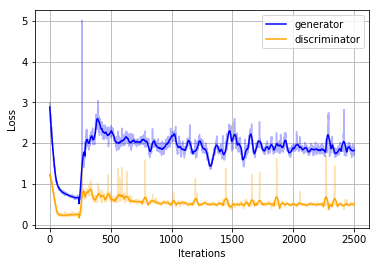

In [75]:
#%matplotlib notebook
plt.plot(np.array(log["g_loss"])[:,0], alpha=0.3,c="b")
plt.plot(np.array(log["d_loss"])[:,0],alpha=0.3, c="orange")

#plt.plot(np.array(log["g_loss"])[:,1], alpha=0.9,c="green", label="L1 objective")

plt.plot(src.smooth(np.array(log["g_loss"])[:,0]),c="b", label="generator")
plt.plot(src.smooth(np.array(log["d_loss"])[:,0]),c="orange", label="discriminator")
plt.grid()
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
#plt.savefig("sGAN_training_curves_r")

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


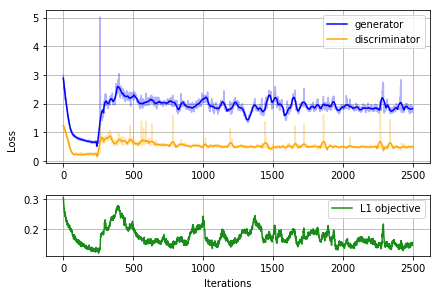

In [76]:
total_g_loss = np.array(log["g_loss"])[:,0]
total_d_loss = np.array(log["d_loss"])[:,0]
smoothed_tgl = src.smooth(np.array(log["g_loss"])[:,0])
smoothed_tdl = src.smooth(np.array(log["d_loss"])[:,0])
objective_loss = np.array(log["g_loss"])[:,1]

# plot 'em
f, (a0, a1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[5, 2]})
a0.plot(total_g_loss, alpha=0.3, c="b")
a0.plot(total_d_loss, alpha=0.3, c="orange")
a0.plot(smoothed_tgl, c="b", label="generator")
a0.grid()
a0.plot(smoothed_tdl, c="orange", label="discriminator")
a0.legend()
a1.plot(objective_loss, alpha=0.9, c="green", label="L1 objective")
a1.grid()
a1.legend()
f.text(0.5, 0, 'Iterations', ha='center', va='center')
f.text(0, 0.5, 'Loss', ha='center', va='center', rotation='vertical')

f.tight_layout()
f.savefig(name+'_curves.png')

## Save features

Save model history

In [77]:
np.save(name+"_log",log)

Save model weights

In [78]:
combined.save_weights(name+"_model.h5")

Load model and predict

In [ ]:
combined.load_weights(sys.path[1]+"/"+name+"/"+name+"_model.h5")

Predict future frames

In [79]:
train, xval, test = src.load_datasets(past_frames=8)

Training data: (7500, 64, 64, 8)
Validation data: (1500, 64, 64, 8)
Test data: (1000, 64, 64, 8)


In [80]:
test_data = src.augment_data(test[:100])

In [81]:
test_data.shape

(400, 64, 64, 8)

In [82]:
generator = combined.layers[1]

In [83]:
#test
predictions = {}
past_frames = test_data[...,0:past]
test_truth = test_data[...,past:past+1]
for t in range(4): #predict 4 next
    future = generator.predict(past_frames, batch_size=64)
    predictions[f"{t}"] = future
    past_frames = np.concatenate((past_frames[:,:,:,1:], predictions[f"{t}"]), axis=-1)
    test_truth = test_data[...,past+1+t:past+2+t]

Save example predictions

In [84]:
def save_examples(name, test, predictions_dict, past, samples=0):
    fig, axs = plt.subplots(len(samples)*2,past+4, figsize=(32, 32))
    fig.subplots_adjust(wspace=0.3, hspace=0.0)
    for n in range(len(samples)):
        vmax = np.max(test[n,:,:,:past])
        vmin = 0
        print(test.shape)
        for i in range(past):
            im = axs[2*n,i].imshow(test[samples[n], :,:,i], vmax=vmax,vmin=vmin)
            axs[2*n,i].axis('off')
            axs[2*n,i].set_title(f"Past frame {i+1}")
            src.colorbar(im)
            im = axs[2*n+1,i].imshow(test[samples[n], :,:,i], vmax=vmax,vmin=vmin)
            axs[2*n+1,i].axis('off')
            axs[2*n+1,i].set_title(f"Past frame {i+1}")
            src.colorbar(im)
        for i in range(past,past+4):
            im = axs[2*n,i].imshow(predictions_dict[f"{i-past}"][samples[n], :,:,0], vmax=vmax, vmin=vmin)
            axs[2*n,i].axis('off')
            axs[2*n,i].set_title(f"Predicted frame {i-past+1}")
            src.colorbar(im)
            im = axs[2*n+1,i].imshow(test[samples[n], :,:,i], vmax=vmax, vmin=vmin)
            axs[2*n+1,i].axis('off')
            axs[2*n+1,i].set_title(f"Reference frame {i-past+1}")
            src.colorbar(im)
    fig.savefig(f"Plots/{name}_sequence_prediction.png")
    plt.close()


In [85]:
save_examples(name, test_data, predictions, past, samples=[33,46,54])

(400, 64, 64, 8)
(400, 64, 64, 8)
(400, 64, 64, 8)


Calculate scores

In [86]:
list(predictions.keys())

['0', '1', '2', '3']

In [87]:
norms = np.load(sys.path[0]+"/5min_norms_compressed.npz")["arr_1"]

In [88]:
# *4 bc of augmentaion (it concats the frames so the 0th 1000th 2000th and 3000th are the same sample just rotated)
test_norms = list(norms[9000:])*4

In [89]:
#renormalize test samples
renormalized_test = np.array([sample * np.array(test_norms)[i] for i, sample in enumerate(test_data)])
renormalized_predictions = np.transpose((np.array([[sample * np.array(test_norms)[i] for i, sample in enumerate(predictions[key])] for key in ['0', '1', '2', '3']])[:,:,:,:,0]), (1,2,3,0))

In [90]:
renormalized_predictions.shape

(400, 64, 64, 4)

In [91]:
#thresholds: 2, 8, 42
thresholds = [10, 50, 100]
scores = {}
for t in range(renormalized_predictions.shape[-1]): # loop over the predictions (4)
    for s in thresholds: # make a dict entry for each threshold score
        scores[f"pred_{t+1}_threshold_{s}"] = src.calculate_skill_scores(renormalized_predictions[...,t:t+1],
                                                                                     renormalized_test[...,past+t:past+1+t],
                                                                                     x=renormalized_test[...,:past],
                                                                                     threshold=s)

C:\Users\pkicsiny\Desktop\TUM\3\ADL4CV\ADL4CV_project\src.py:846: RuntimeWarning: invalid value encountered in true_divide
  scores["csi"] = hits/(hits+misses+false_alarms)
C:\Users\pkicsiny\Desktop\TUM\3\ADL4CV\ADL4CV_project\src.py:848: RuntimeWarning: invalid value encountered in true_divide
  scores["far"] = false_alarms/(hits+false_alarms)
C:\Users\pkicsiny\Desktop\TUM\3\ADL4CV\ADL4CV_project\src.py:850: RuntimeWarning: invalid value encountered in true_divide
  scores["pod"] = hits/(hits+misses)


In [92]:
scores["pred_1_threshold_10"].keys()

dict_keys(['csi', 'far', 'pod', 'corr_to_truth', 'corr_to_input'])

In [93]:
np.save(name+"_scores",scores)

In [ ]:
name

In [ ]:
loaded_scores = np.load(sys.path[1]+"/"+name"/"+name+"_scores.npy").item()

In [ ]:
list(loaded_scores.keys())

In [96]:
np.mean((pd.Series(scores["pred_1_threshold_100"]["corr_to_truth"]).dropna()))

0.680957655649904

In [97]:
np.mean((pd.Series(scores["pred_2_threshold_100"]["corr_to_truth"]).dropna()))

0.5759598183319592

In [100]:
np.mean((pd.Series(scores["pred_3_threshold_100"]["corr_to_input"]).dropna()))

0.5785979297233402

In [101]:
np.mean((pd.Series(scores["pred_4_threshold_100"]["corr_to_truth"]).dropna()))

0.43733058747642894

In [ ]:
def wasserstein_loss(y_true, y_pred):
    """Calculates the Wasserstein loss for a sample batch.
    The Wasserstein loss function is very simple to calculate. In a standard GAN, the discriminator
    has a sigmoid output, representing the probability that samples are real or generated. In Wasserstein
    GANs, however, the output is linear with no activation function! Instead of being constrained to [0, 1],
    the discriminator wants to make the distance between its output for real and generated samples as large as possible.
    The most natural way to achieve this is to label generated samples -1 and real samples 1, instead of the
    0 and 1 used in normal GANs, so that multiplying the outputs by the labels will give you the loss immediately.
    Note that the nature of this loss means that it can be (and frequently will be) less than 0."""
    return K.mean(y_true * y_pred)

In [ ]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
layer_name = 'block5_conv3'
filter_index = 0  # can be any integer from 0 to 511, as there are 512 filters in that layer

# build a loss function that maximizes the activation
# of the nth filter of the layer considered
layer_output = layer_dict[layer_name].output
K.mean(layer_output[:, :, :, filter_index])